# Titanic

https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling/notebook

## 1. Import libraries and load datasets

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.family'] = 'Avenir'

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

## 2. Load and check Data

### 2.1 Load data

In [91]:
# Load data
#### Load train and Test datasets

train = pd.read_csv('~/aiffel/data/titanic_train.csv')
test = pd.read_csv('~/aiffel/data/titanic_test.csv')
IDtest = test['PassengerId']

In [92]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [93]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### 2.2 Outlier detection

In [94]:
# Outlier detection

def detect_outliers(df, n, features):
    '''
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    '''
    outlier_indices = []

    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col], 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1

        # Outlier step
        outlier_step = 1.5 * IQR

        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index

        # Append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)

    # Select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n)

    return multiple_outliers

# Detect outliers from Age, SibSp, Parch and Fare
Outliers_to_drop = detect_outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])

In [95]:
# show the outliers
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


PassenderId 28, 89, and 342 have high Fare amount.

The others have high SibSp number.

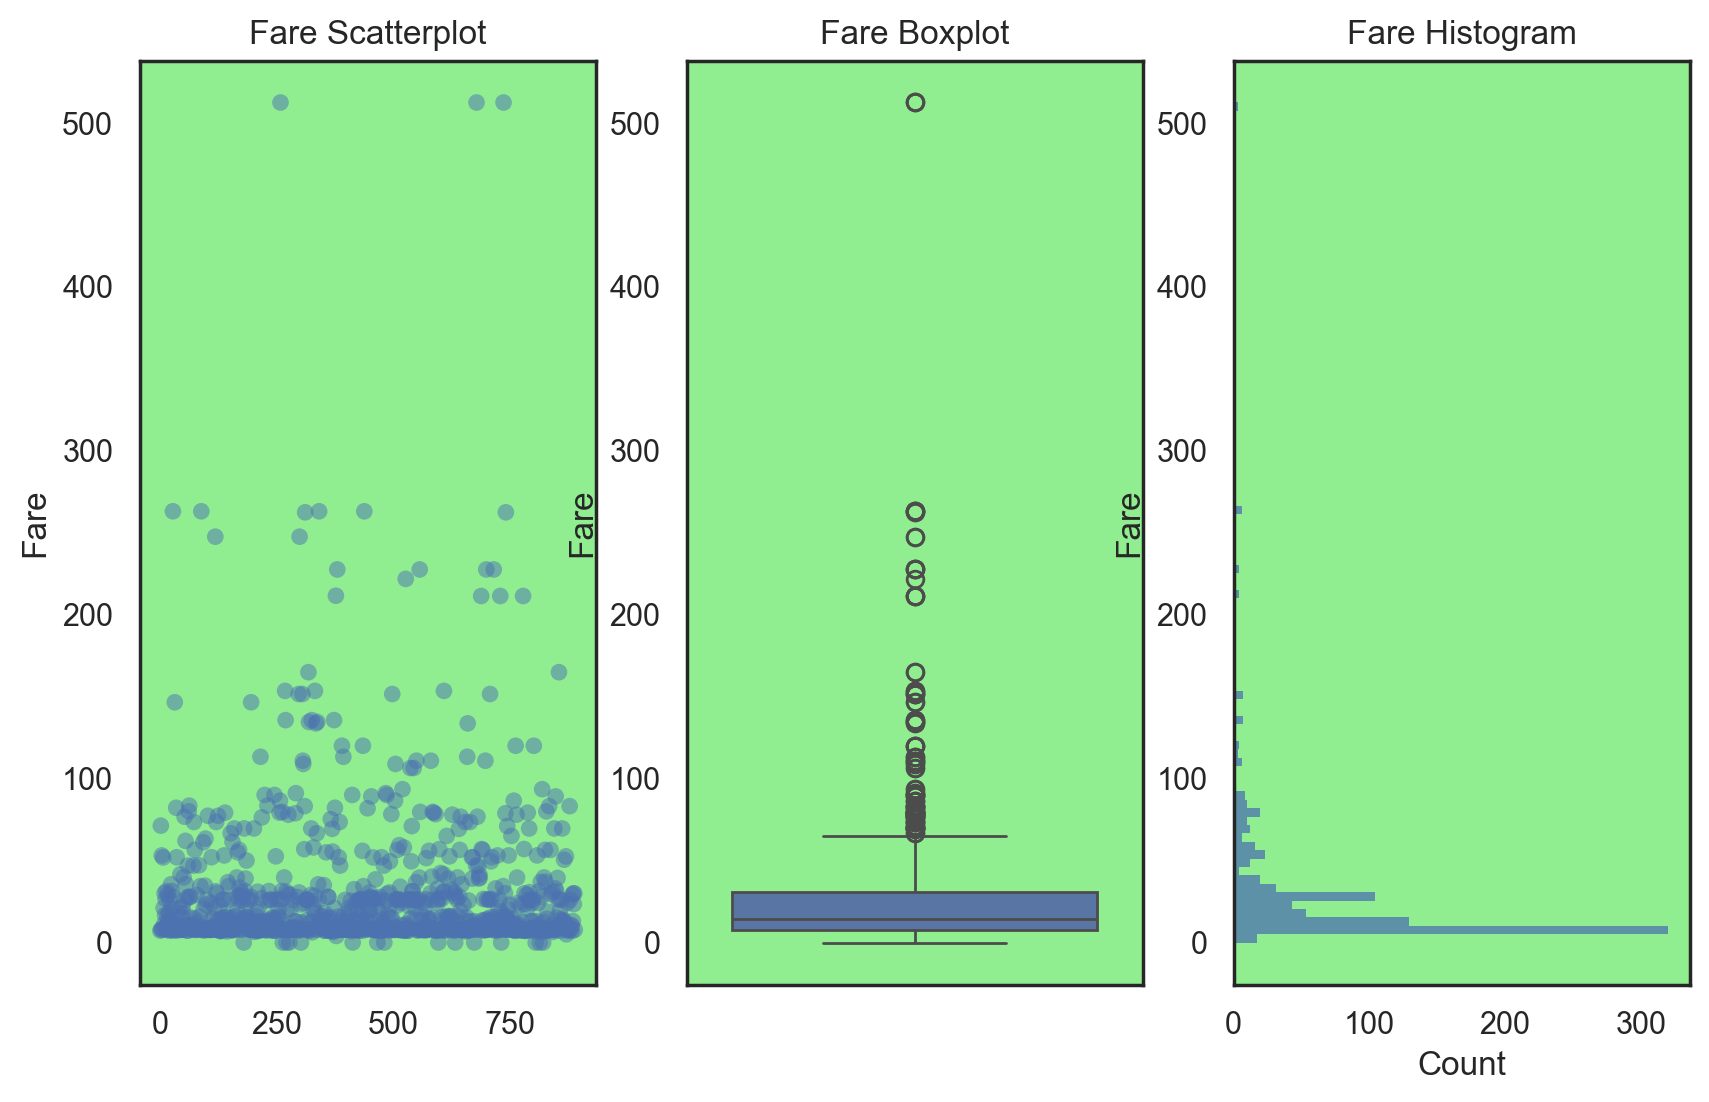

In [96]:
f, ax = plt.subplots(1, 3, figsize = (10, 6))

sns.scatterplot(x = train.index, y = 'Fare', data = train, ax = ax[0], alpha = 0.5, edgecolor = 'none')
ax[0].set_title('Fare Scatterplot')
ax[0].set_xlabel('')
ax[0].set_facecolor('lightgreen')

sns.boxplot(y = 'Fare', data = train, ax = ax[1])
ax[1].set_title('Fare Boxplot')
ax[1].set_facecolor('lightgreen')


sns.histplot(y = 'Fare', data = train, bins = 100, edgecolor = 'none', ax = ax[2])
ax[2].set_title('Fare Histogram')
ax[2].set_facecolor('lightgreen')

In [97]:
train['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [98]:
Q1 = np.percentile(train['Fare'], 25)
Q3 = np.percentile(train['Fare'], 75)
IQR = Q3 - Q1
outlier_step = 1.5 * IQR
outlier_low = Q1 - outlier_step
outlier_high = Q3 + outlier_step

print('Q1:', Q1)
print('Q3:', Q3)
print('IQR:', IQR)
print('outlier_step:', outlier_step)
print('outlier_low:', outlier_low)
print('outlier_high:', outlier_high)

Q1: 7.9104
Q3: 31.0
IQR: 23.0896
outlier_step: 34.6344
outlier_low: -26.724
outlier_high: 65.6344


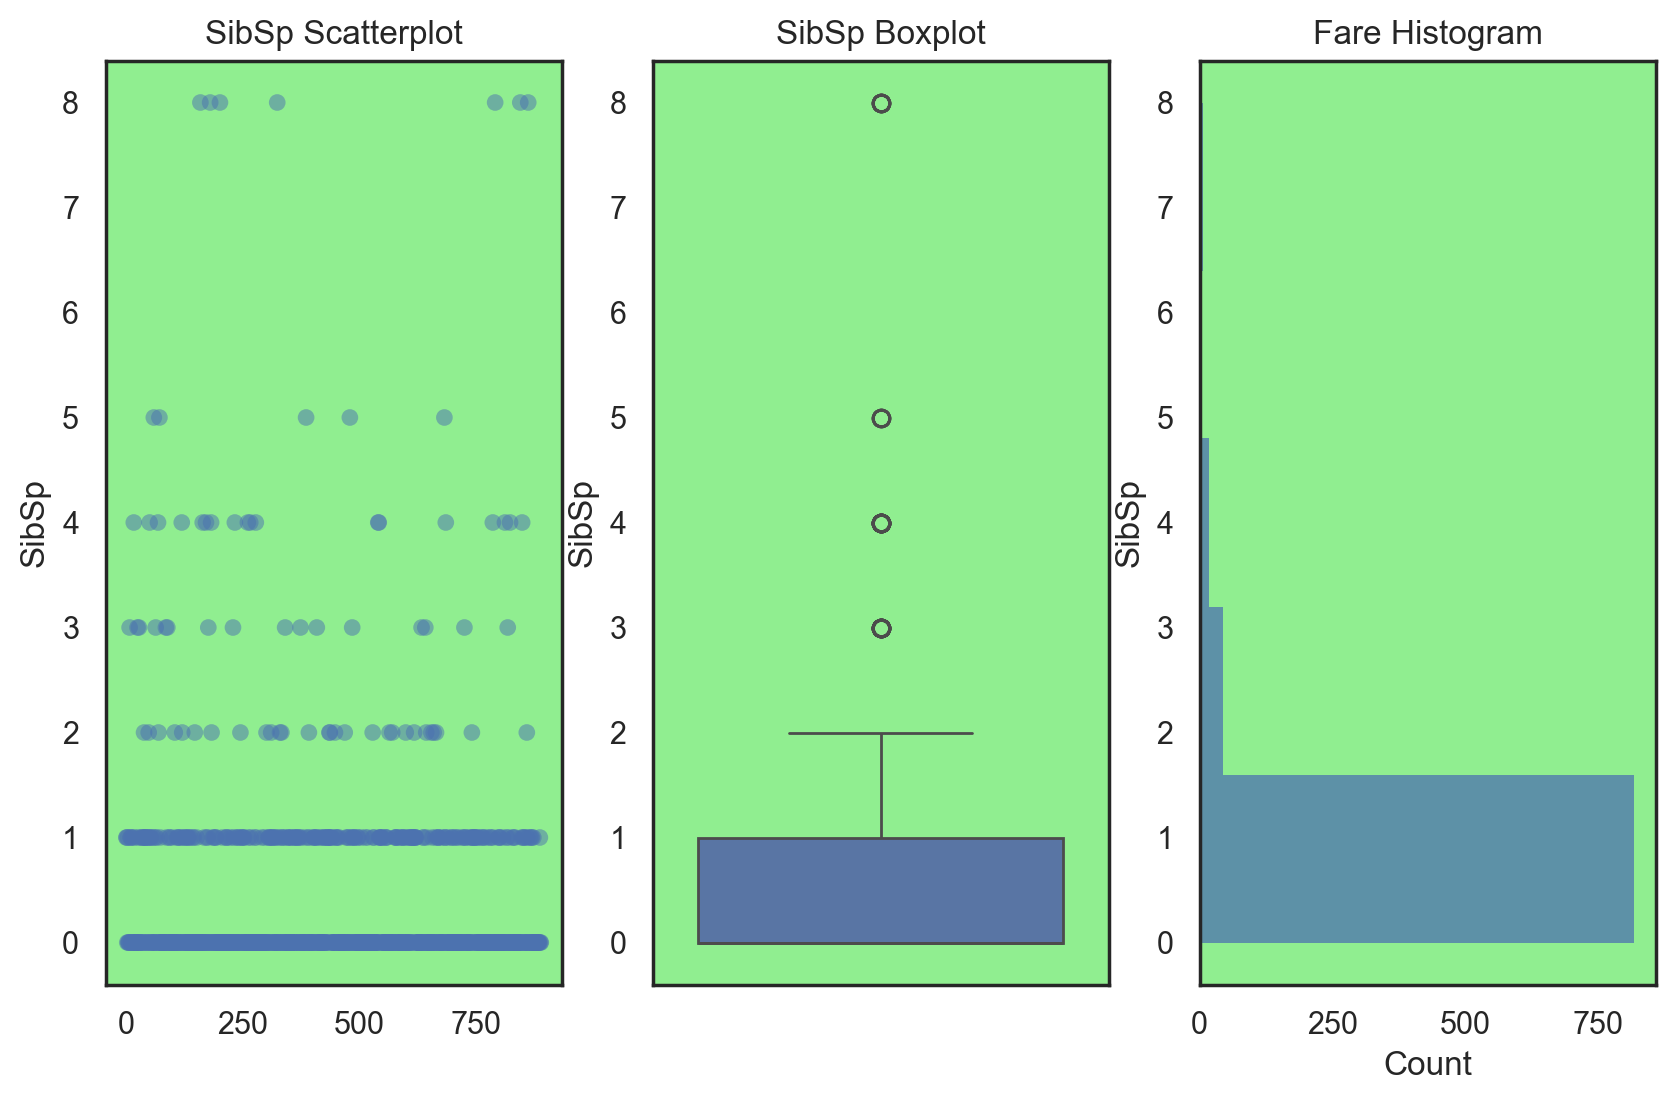

In [99]:
f, ax = plt.subplots(1, 3, figsize = (10, 6))

sns.scatterplot(x = train.index, y = 'SibSp', data = train, ax = ax[0], alpha = 0.5, edgecolor = 'none')
ax[0].set_title('SibSp Scatterplot')
ax[0].set_xlabel('')
ax[0].set_facecolor('lightgreen')

sns.boxplot(y = 'SibSp', data = train, ax = ax[1])
ax[1].set_title('SibSp Boxplot')
ax[1].set_facecolor('lightgreen')


sns.histplot(y = 'SibSp', data = train, bins = 5, edgecolor = 'none', ax = ax[2])
ax[2].set_title('Fare Histogram')
ax[2].set_facecolor('lightgreen')

In [100]:
train['SibSp'].describe()

count    891.000000
mean       0.523008
std        1.102743
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: SibSp, dtype: float64

In [101]:
Q1 = np.percentile(train['SibSp'], 25)
Q3 = np.percentile(train['SibSp'], 75)
IQR = Q3 - Q1
outlier_step = 1.5 * IQR
outlier_low = Q1 - outlier_step
outlier_high = Q3 + outlier_step

print('Q1:', Q1)
print('Q3:', Q3)
print('IQR:', IQR)
print('outlier_step:', outlier_step)
print('outlier_low:', outlier_low)
print('outlier_high:', outlier_high)

Q1: 0.0
Q3: 1.0
IQR: 1.0
outlier_step: 1.5
outlier_low: -1.5
outlier_high: 2.5


In [102]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop = True)

### 2.3 Joining train and test set

In [103]:
# Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset = pd.concat(objs = [train, test], axis = 0).reset_index(drop = True)

In [104]:
train_len

881

In [105]:
dataset

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1294,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1295,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1296,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1297,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


### 2.4 Check for null and missing values

In [106]:
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [107]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [108]:
# Infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [109]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [110]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [111]:
# Summarize data
# Summarie and statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## 3. Feature analysis

### 3.1 Numerical values

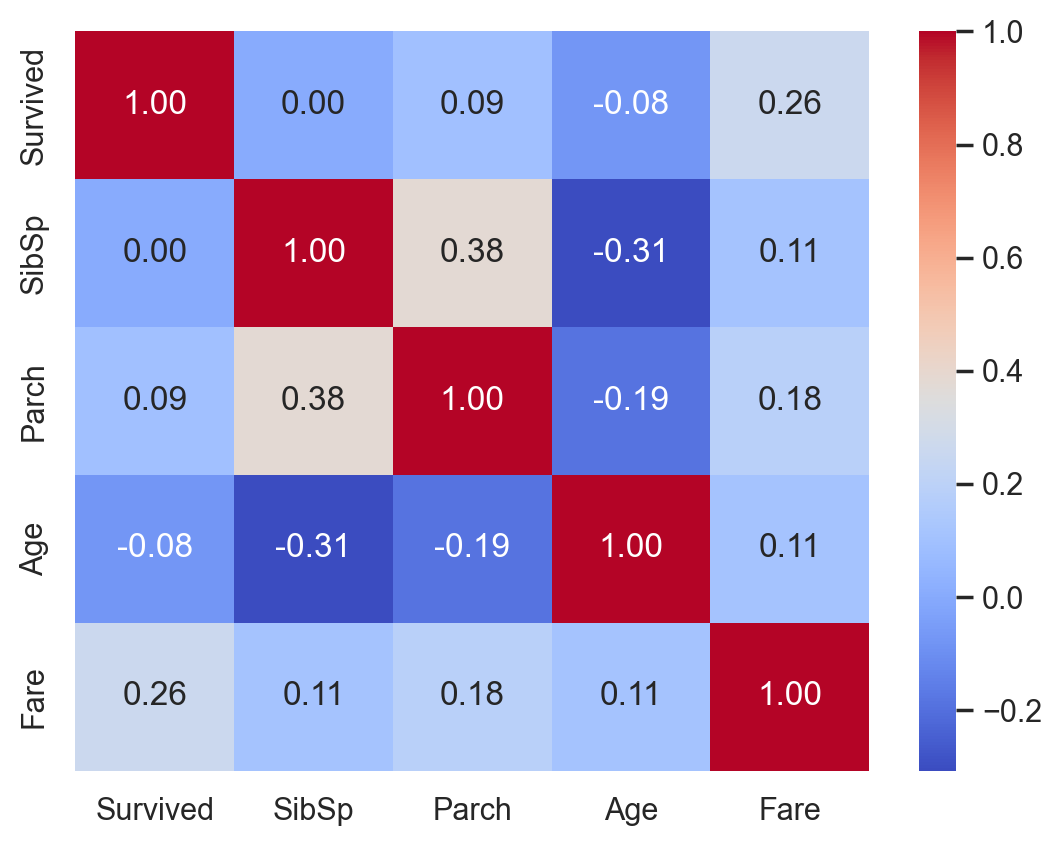

In [112]:
# Correlation matrix between numerical values (SibSp, Parch, Age, and Fare values) and Survived

g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot = True, fmt = '.2f', cmap = 'coolwarm')

### SibSp

/var/folders/b9/d_8nll_s47g6w2x0spndwwl80000gn/T/ipykernel_28272/2069855596.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='SibSp', y='Survived', data=train, kind='bar', height=4, palette='muted')


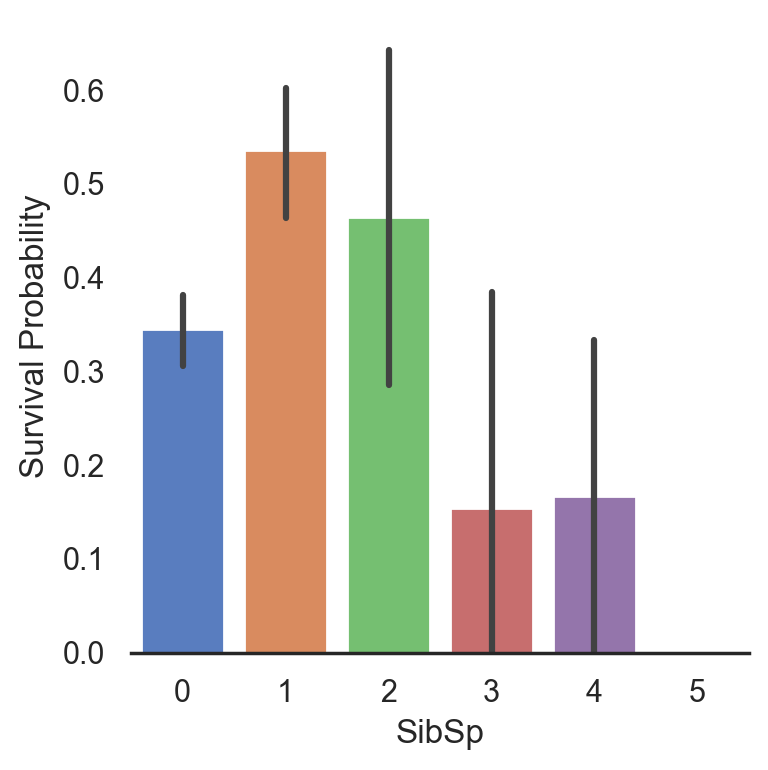

In [113]:
# Explore SibSp feature vs Survived
g = sns.catplot(x='SibSp', y='Survived', data=train, kind='bar', height=4, palette='muted')
g.despine(left=True)
g = g.set_ylabels('Survival Probability')


### Parch

/var/folders/b9/d_8nll_s47g6w2x0spndwwl80000gn/T/ipykernel_28272/2515774204.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x = 'Parch', y = 'Survived', data = train, kind = 'bar', height = 4, palette = 'muted')


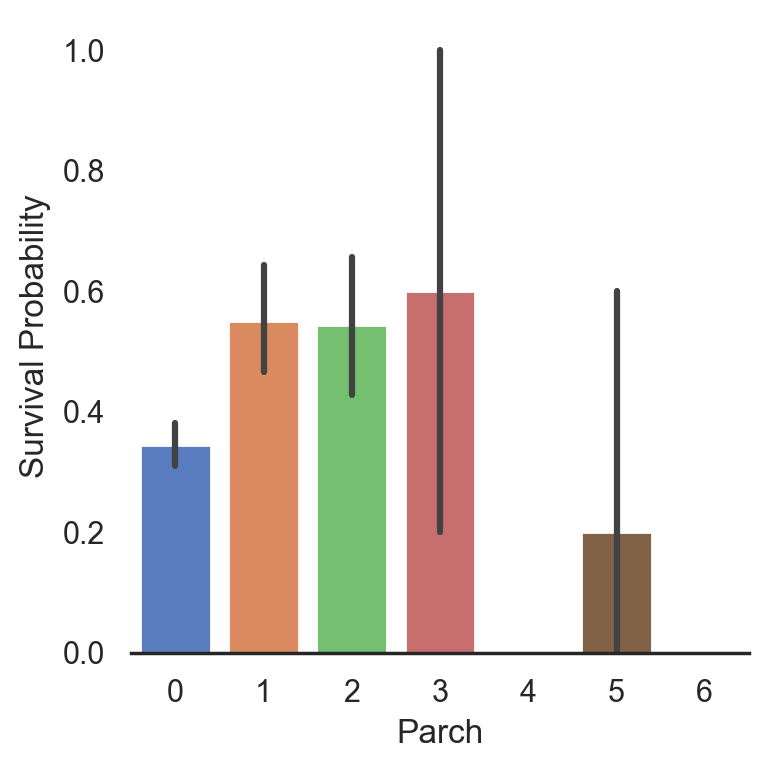

In [114]:
g = sns.catplot(x = 'Parch', y = 'Survived', data = train, kind = 'bar', height = 4, palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('Survival Probability')

### Age

/Users/kenny_jung/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/Users/kenny_jung/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_

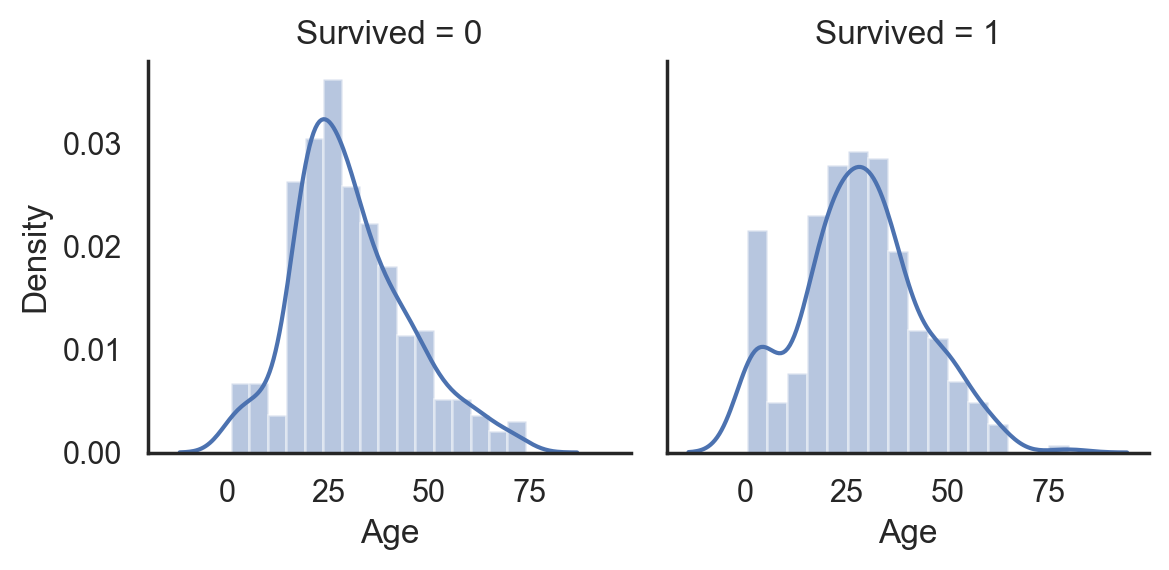

In [115]:
# Explore Age vs Survived
g = sns.FacetGrid(train, col = 'Survived')
g = g.map(sns.distplot, 'Age')

/var/folders/b9/d_8nll_s47g6w2x0spndwwl80000gn/T/ipykernel_28272/2280496246.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  g = sns.kdeplot(train['Age'][(train['Survived'] == 0) & (train['Age'].notnull())], color = 'Red', shade = True)
/var/folders/b9/d_8nll_s47g6w2x0spndwwl80000gn/T/ipykernel_28272/2280496246.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  g = sns.kdeplot(train['Age'][(train['Survived'] == 1) & (train['Age'].notnull())], ax = g, color = 'Green', shade = True)


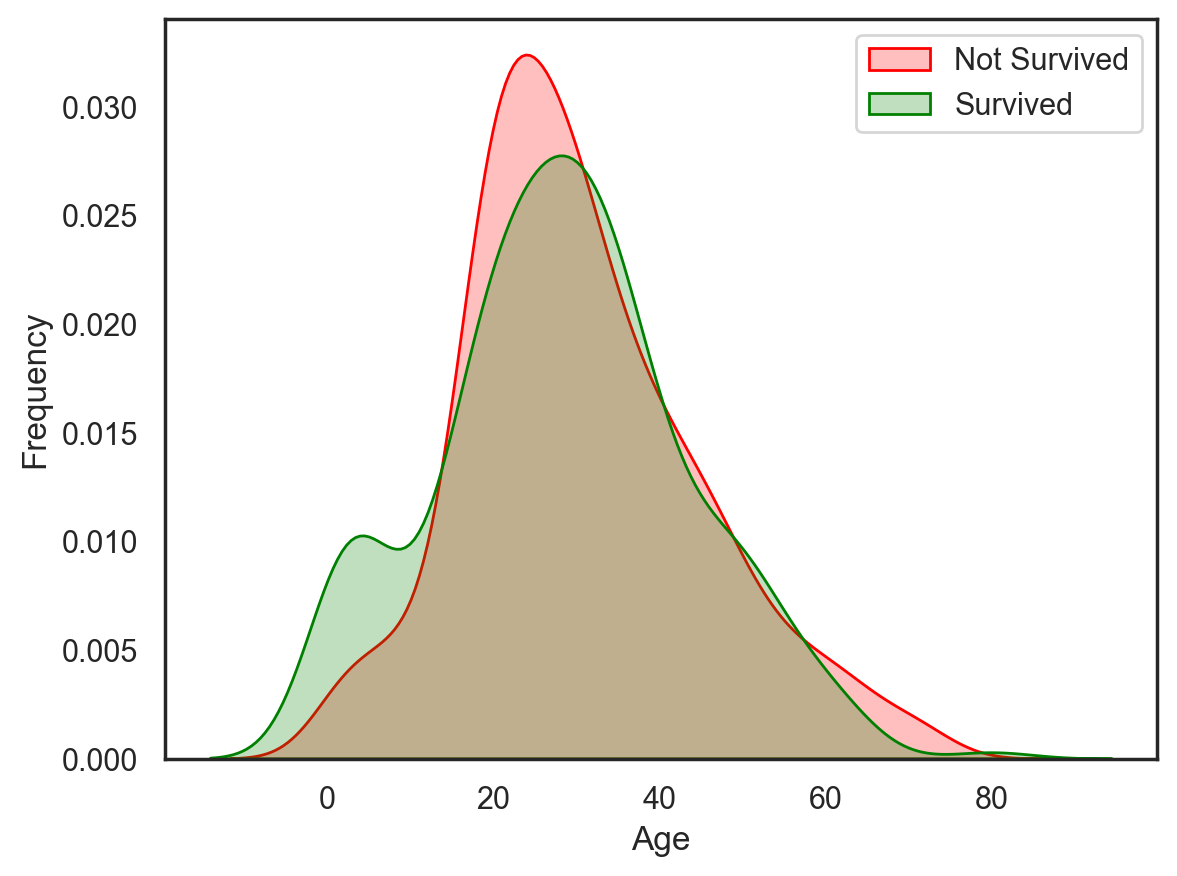

In [116]:
# Explore Age distribution
g = sns.kdeplot(train['Age'][(train['Survived'] == 0) & (train['Age'].notnull())], color = 'Red', shade = True)
g = sns.kdeplot(train['Age'][(train['Survived'] == 1) & (train['Age'].notnull())], ax = g, color = 'Green', shade = True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])

### Fare

In [117]:
dataset['Fare'].isnull().sum()

1

In [118]:
# Fill Fare missing values with the median value
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

/var/folders/b9/d_8nll_s47g6w2x0spndwwl80000gn/T/ipykernel_28272/220858037.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(dataset['Fare'], color = 'm', label = 'Skewness : %.2f'%(dataset['Fare'].skew()))


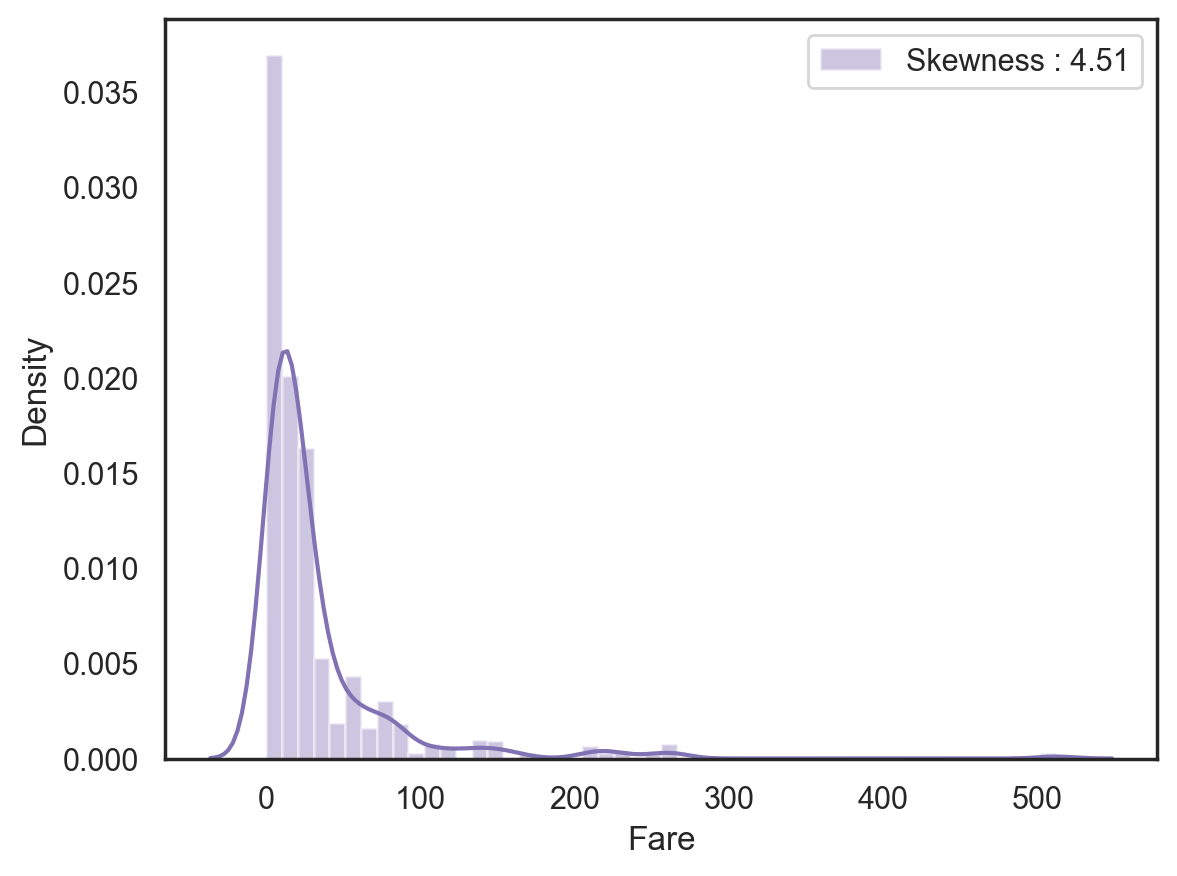

In [119]:
# Explore Fare distribution
g = sns.distplot(dataset['Fare'], color = 'm', label = 'Skewness : %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc = 'best')

In [120]:
# Apply log to Fare to reduce skewness distribution
dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

/var/folders/b9/d_8nll_s47g6w2x0spndwwl80000gn/T/ipykernel_28272/1965388384.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(dataset['Fare'], color = 'm', label = 'Skewness : %.2f'%(dataset['Fare'].skew()))


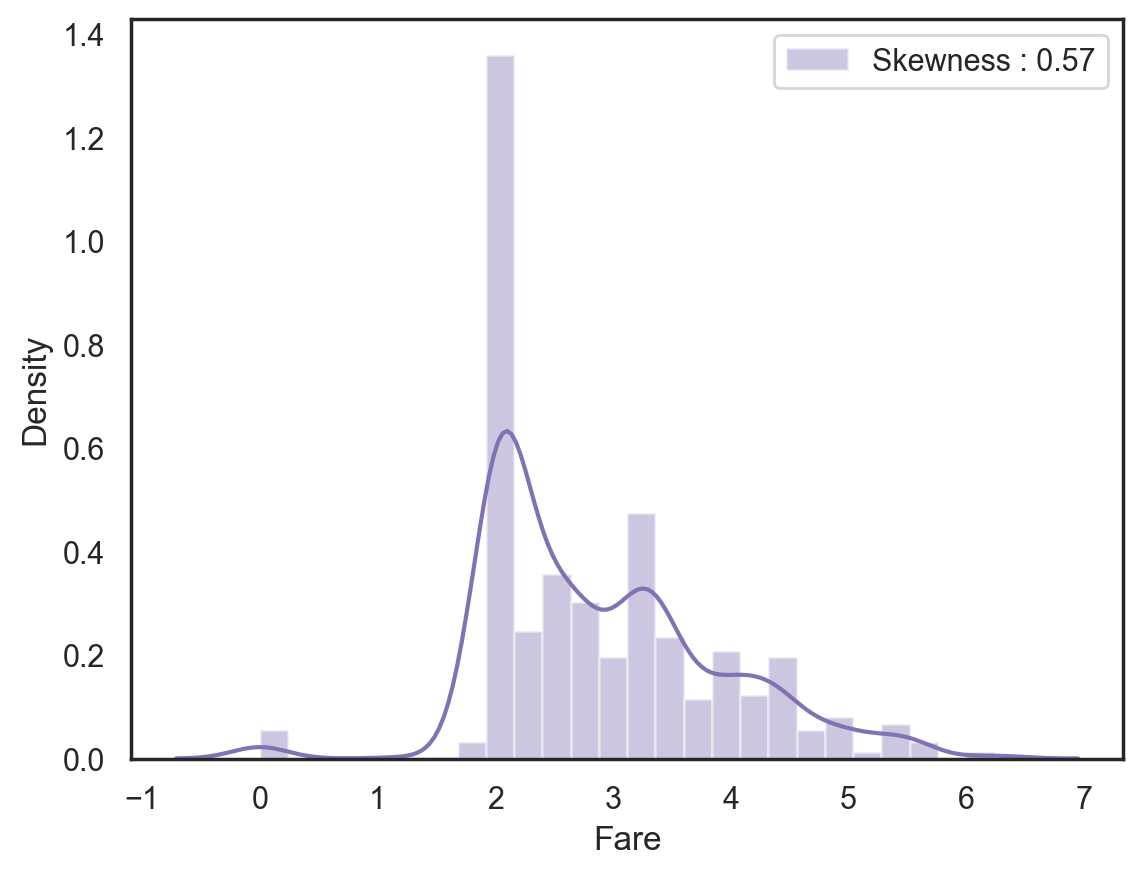

In [121]:
g = sns.distplot(dataset['Fare'], color = 'm', label = 'Skewness : %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc = 'best')

### 3.2 Categorical values

### Sex

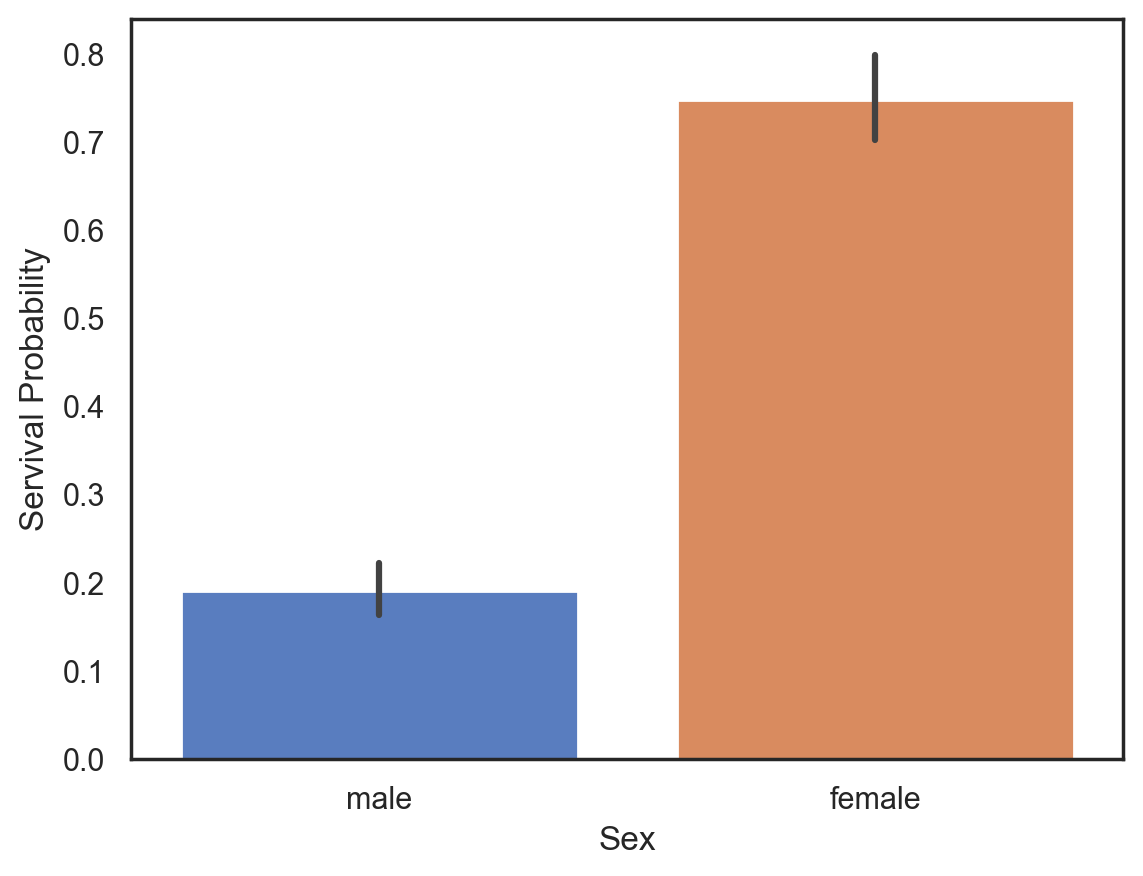

In [122]:
g = sns.barplot(x = 'Sex', y = 'Survived', data = train, hue = 'Sex', palette = 'muted')
g = g.set_ylabel('Servival Probability')

In [123]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


### Plass

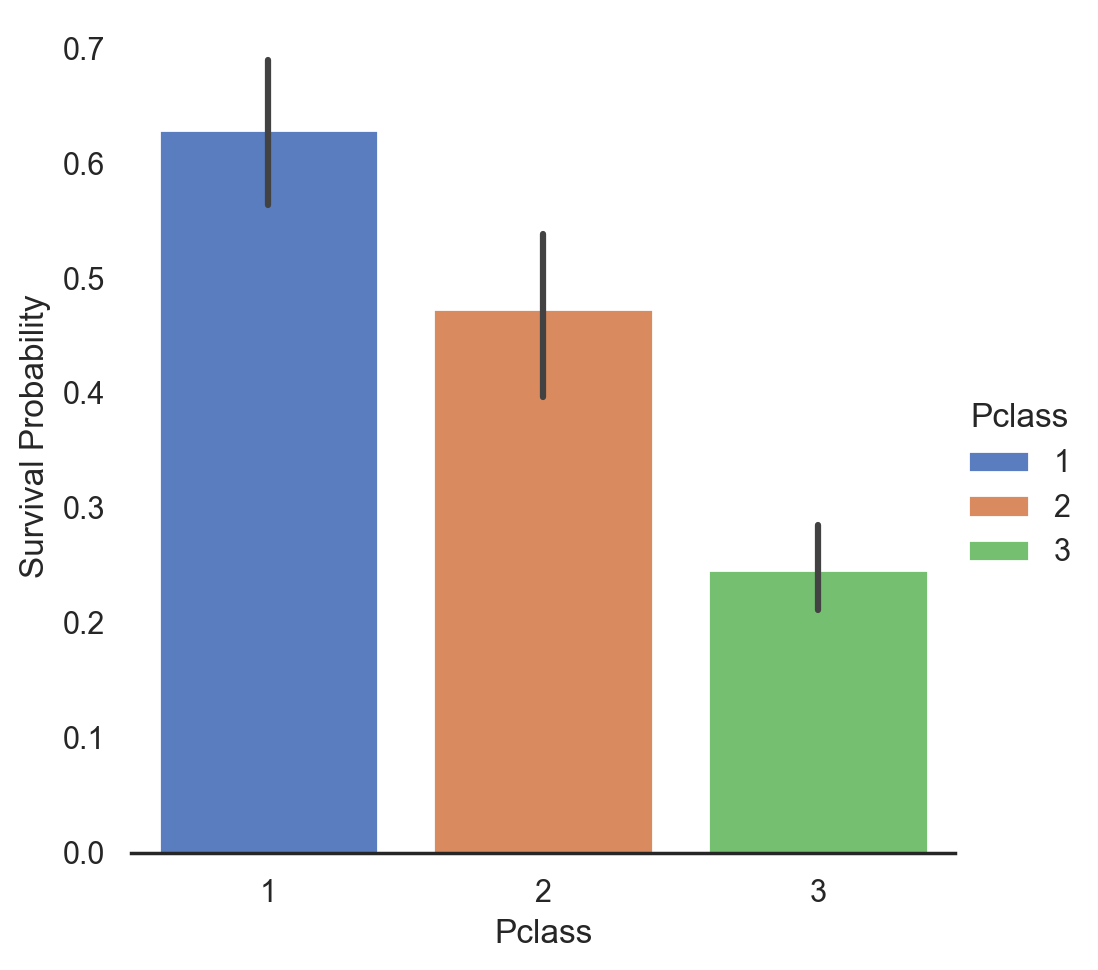

In [124]:
g = sns.catplot(x='Pclass', y='Survived', data=train, hue = 'Pclass', kind = 'bar', palette = 'muted')
g = g.set_ylabels('Survival Probability')
g.despine(left = True)

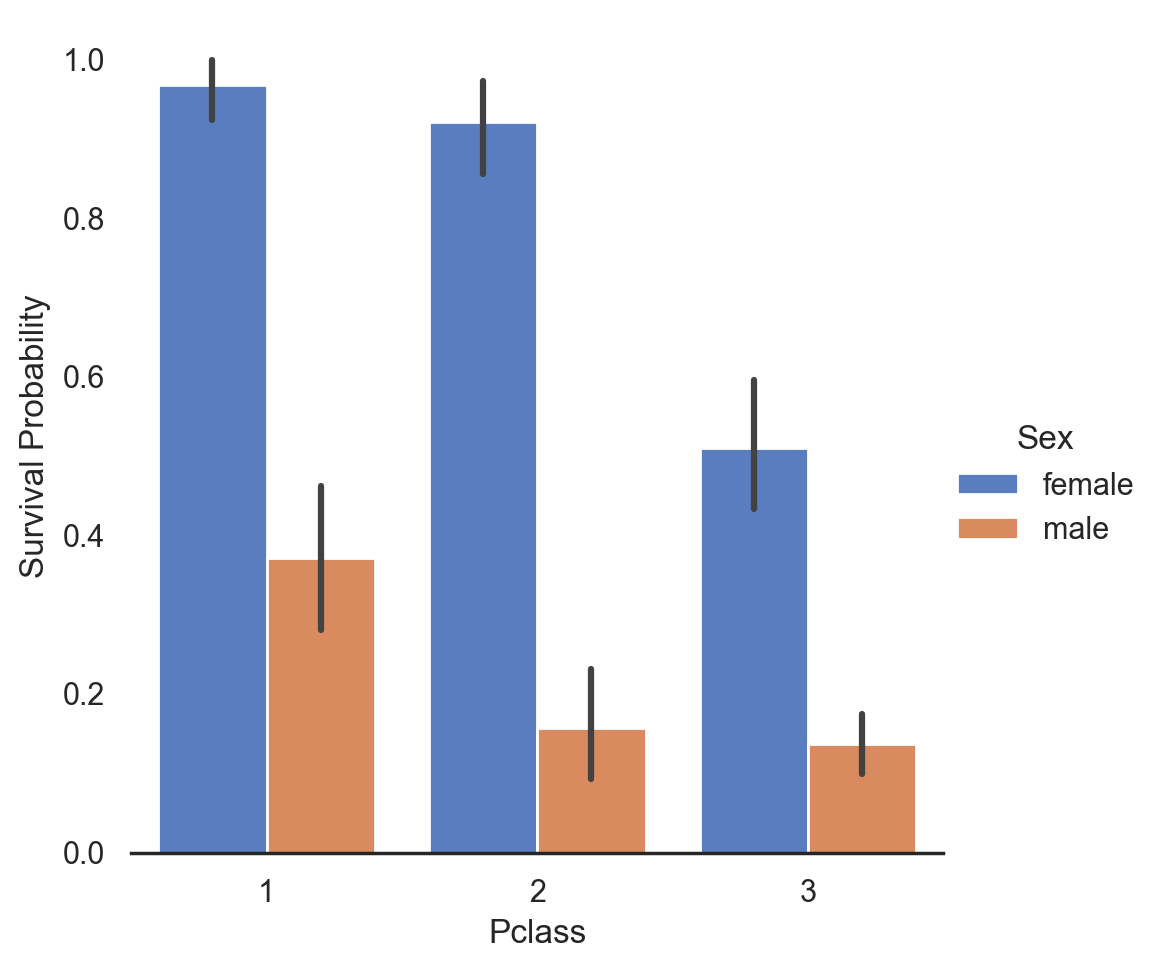

In [125]:
g = sns.catplot(x='Pclass', y='Survived', data=train, hue='Sex', palette='muted', kind='bar')
g = g.set_ylabels('Survival Probability')
g.despine(left = True)


### Embarked

In [126]:
dataset['Embarked'].isnull().sum()

2

In [127]:
dataset['Embarked'] = dataset['Embarked'].fillna('S')

/var/folders/b9/d_8nll_s47g6w2x0spndwwl80000gn/T/ipykernel_28272/3166792715.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x = 'Embarked', y = 'Survived', data = train, kind = 'bar', palette = 'muted')


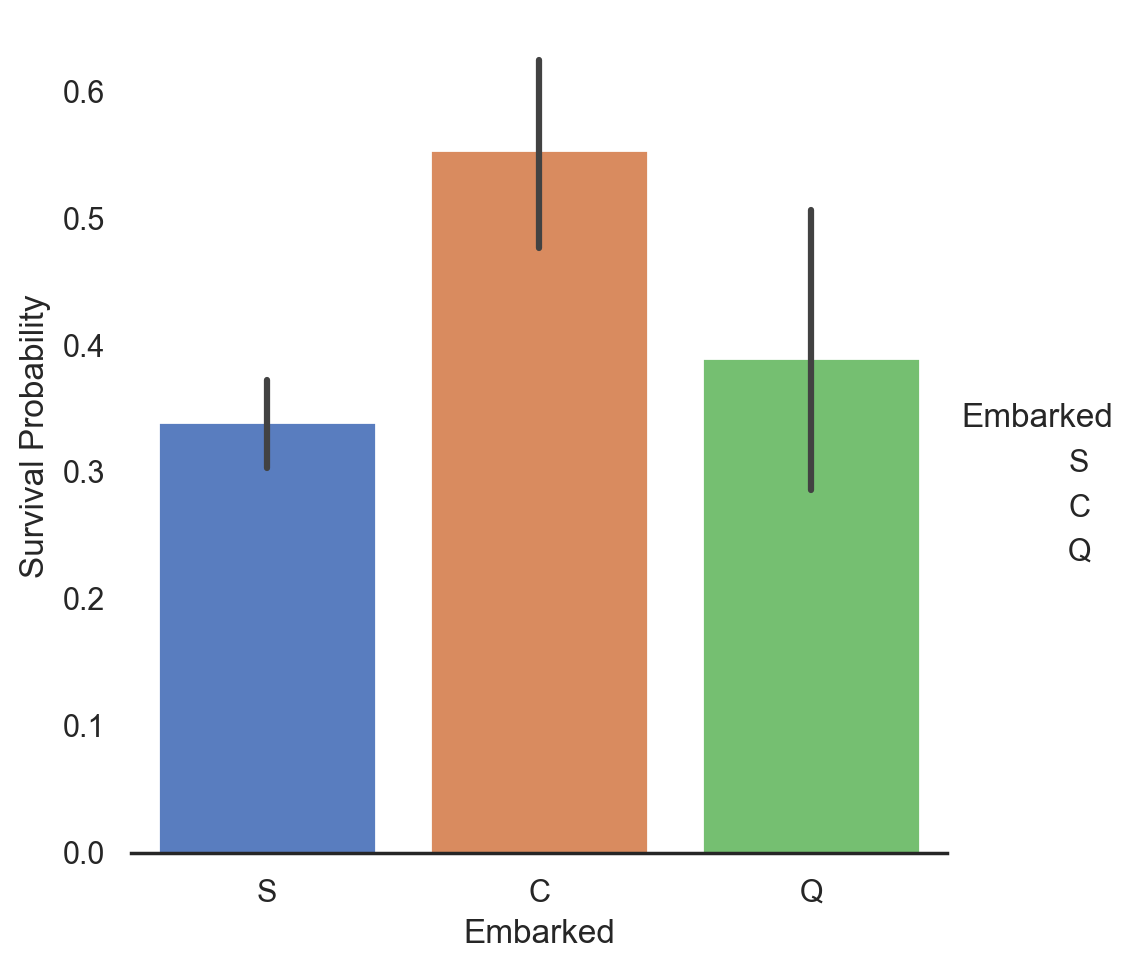

In [128]:
g = sns.catplot(x = 'Embarked', y = 'Survived', data = train, kind = 'bar', palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('Survival Probability')


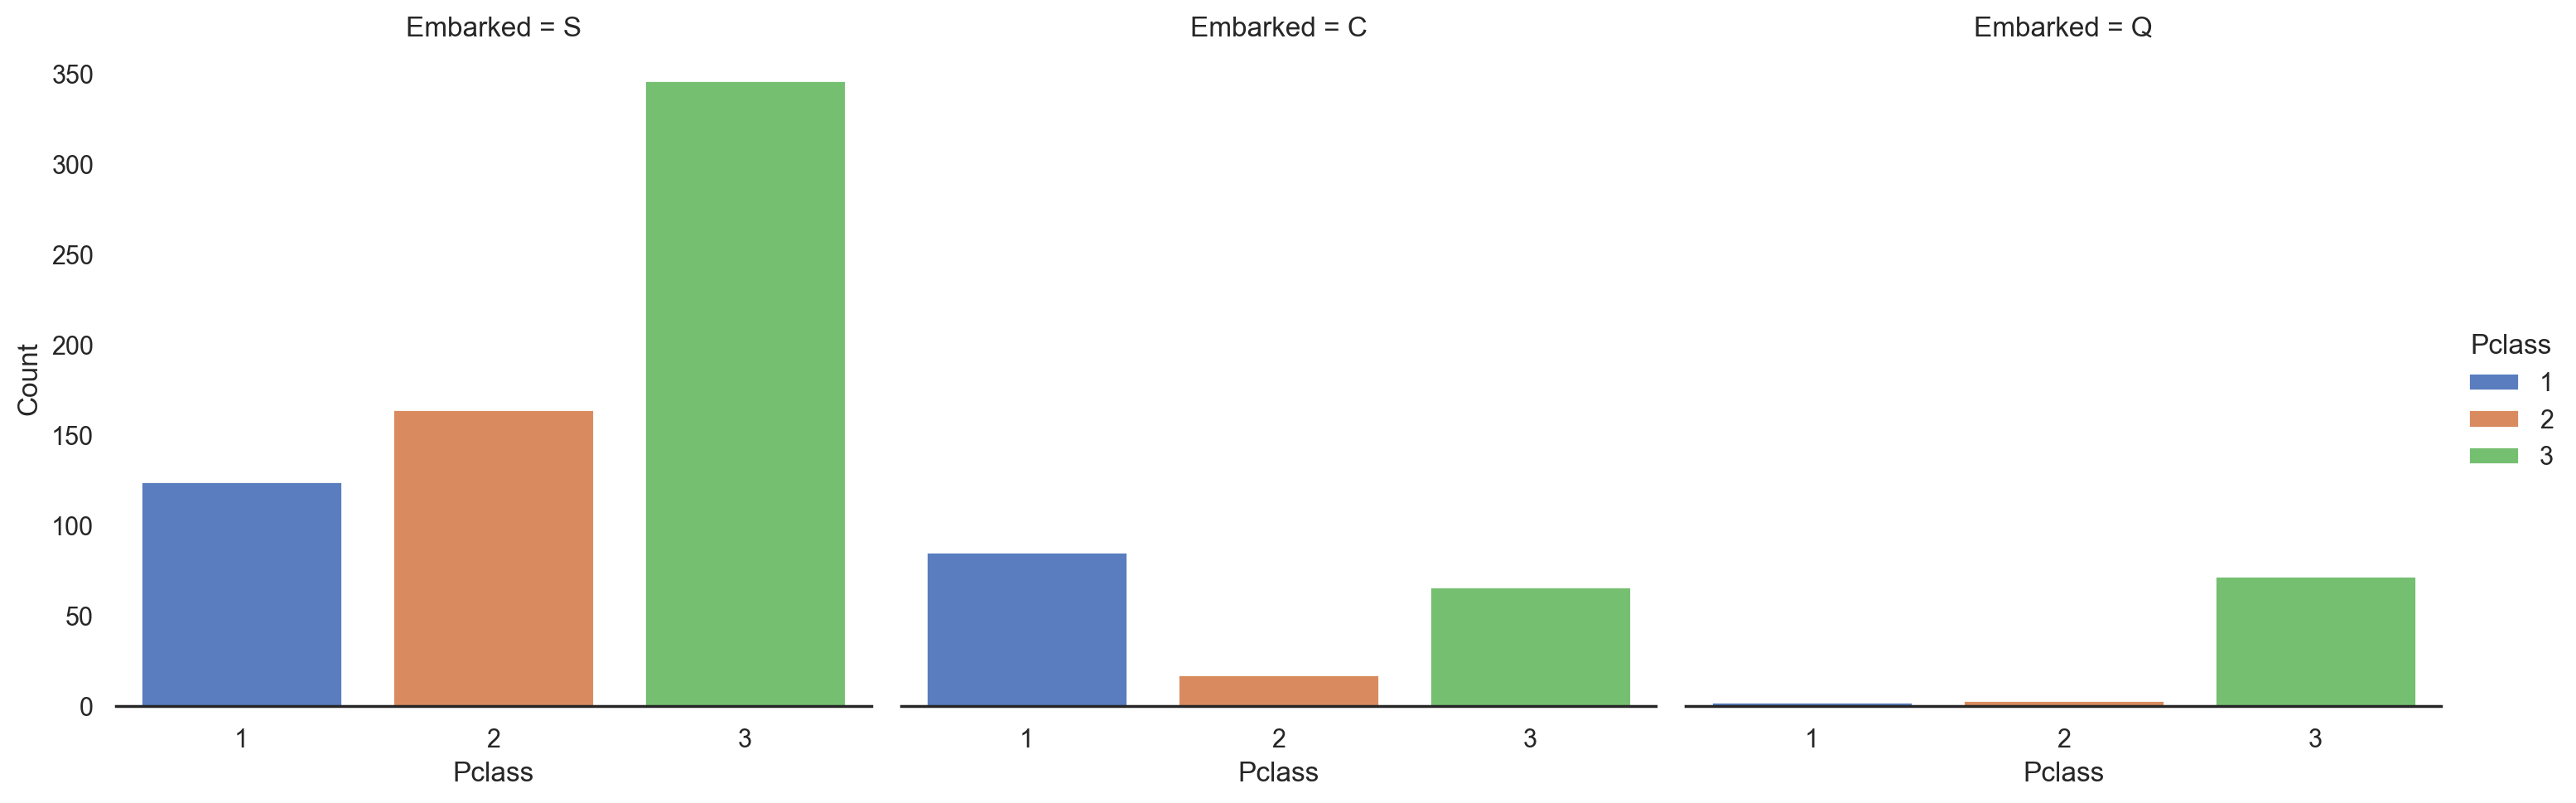

In [129]:
# Explore Pclass vs Embarked
g = sns.catplot(x = 'Pclass', col = 'Embarked', data = train, kind = 'count', hue = 'Pclass', palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('Count')

## 4. Filling missing values

### 4.1 Age

In [130]:
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1007
Embarked          0
dtype: int64

/var/folders/b9/d_8nll_s47g6w2x0spndwwl80000gn/T/ipykernel_28272/3649434243.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x = 'Parch', y = 'Age', data = dataset, kind = 'box', palette = 'muted')
/var/folders/b9/d_8nll_s47g6w2x0spndwwl80000gn/T/ipykernel_28272/3649434243.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x = 'SibSp', y = 'Age', data = dataset, kind = 'box', palette = 'muted')


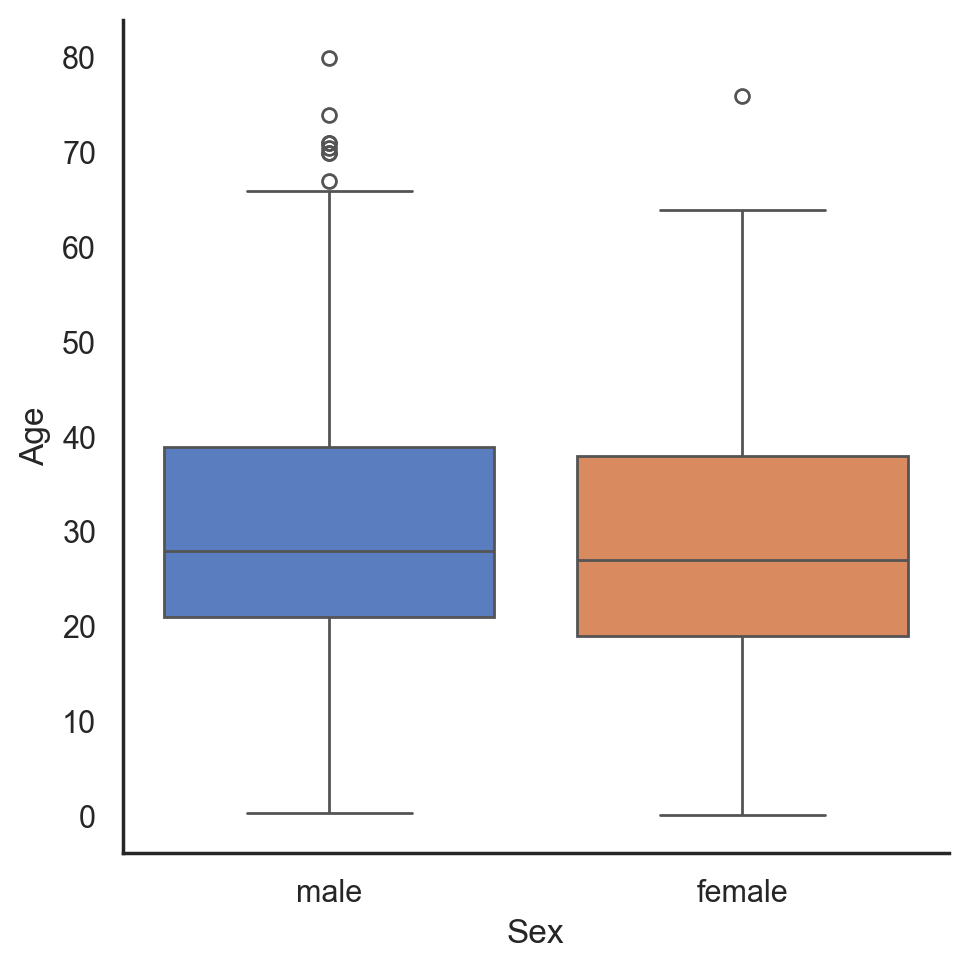

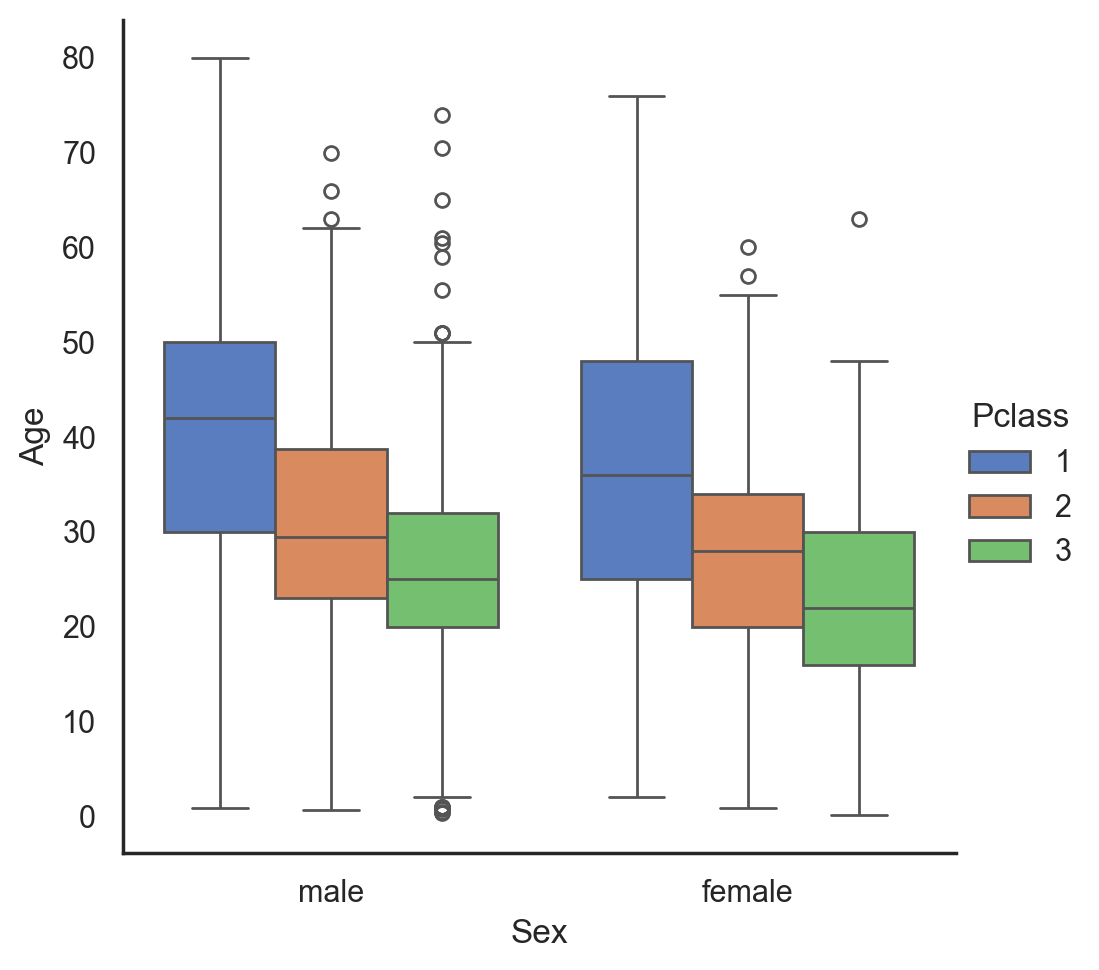

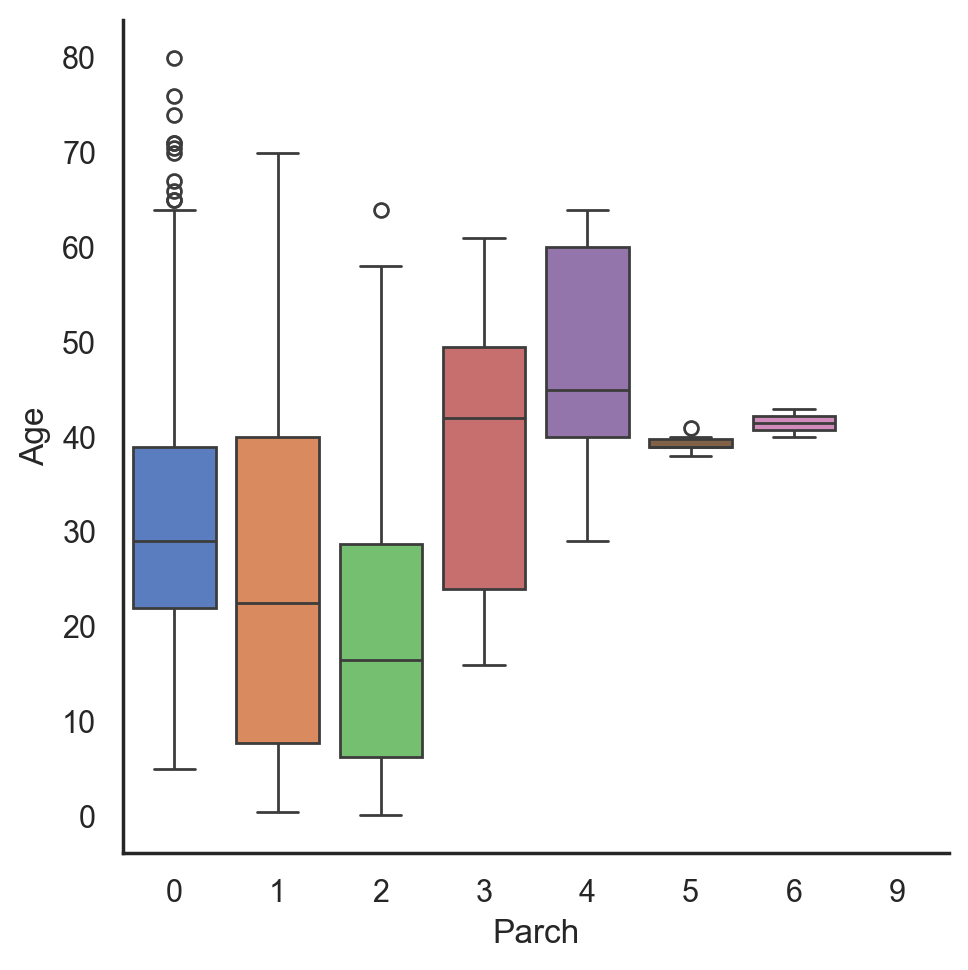

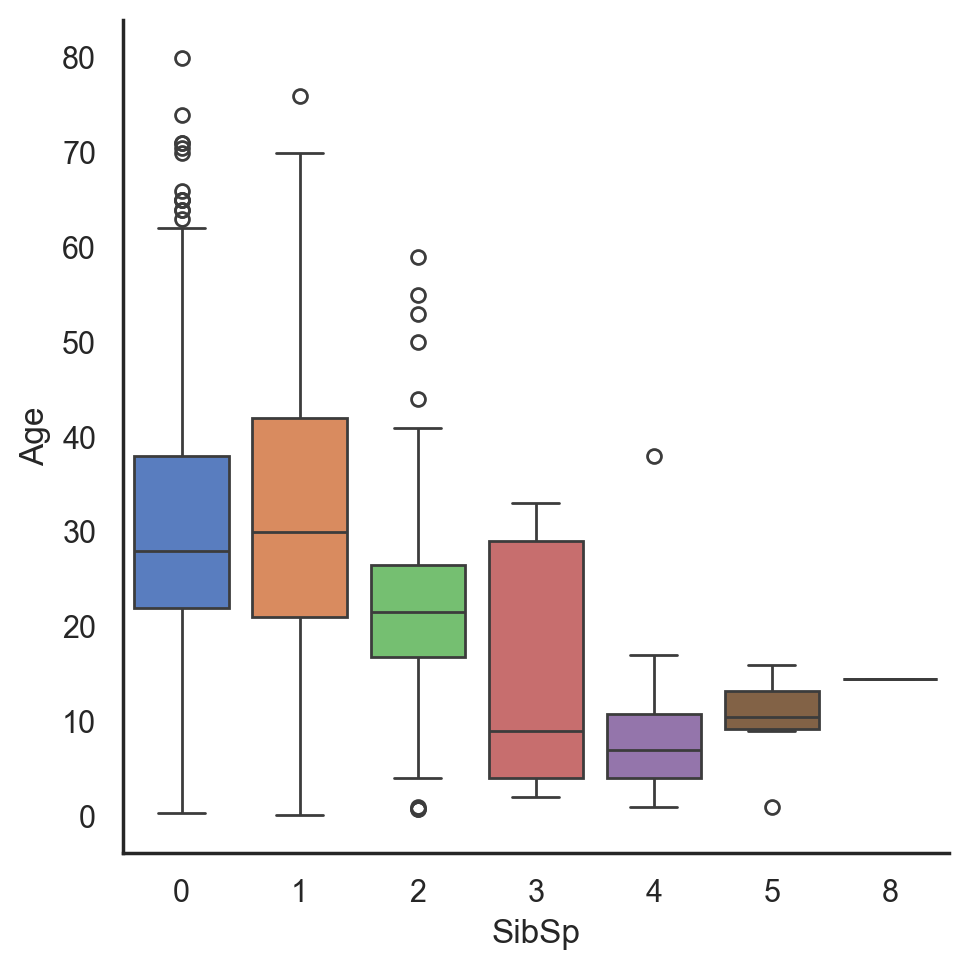

In [131]:
# Explore Age vs. Sex, Parch, Pclass ad SibSp
g = sns.catplot(x = 'Sex', y = 'Age', data = dataset, kind = 'box', hue = 'Sex', palette = 'muted')
g = sns.catplot(x = 'Sex', y = 'Age', data = dataset, kind = 'box', hue = 'Pclass', palette = 'muted')
g = sns.catplot(x = 'Parch', y = 'Age', data = dataset, kind = 'box', palette = 'muted')
g = sns.catplot(x = 'SibSp', y = 'Age', data = dataset, kind = 'box', palette = 'muted')

In [132]:
# Convert Sex into categorical value 0 for male and 1 for female
dataset['Sex'] = dataset['Sex'].map({'male': 0, 'female': 1})

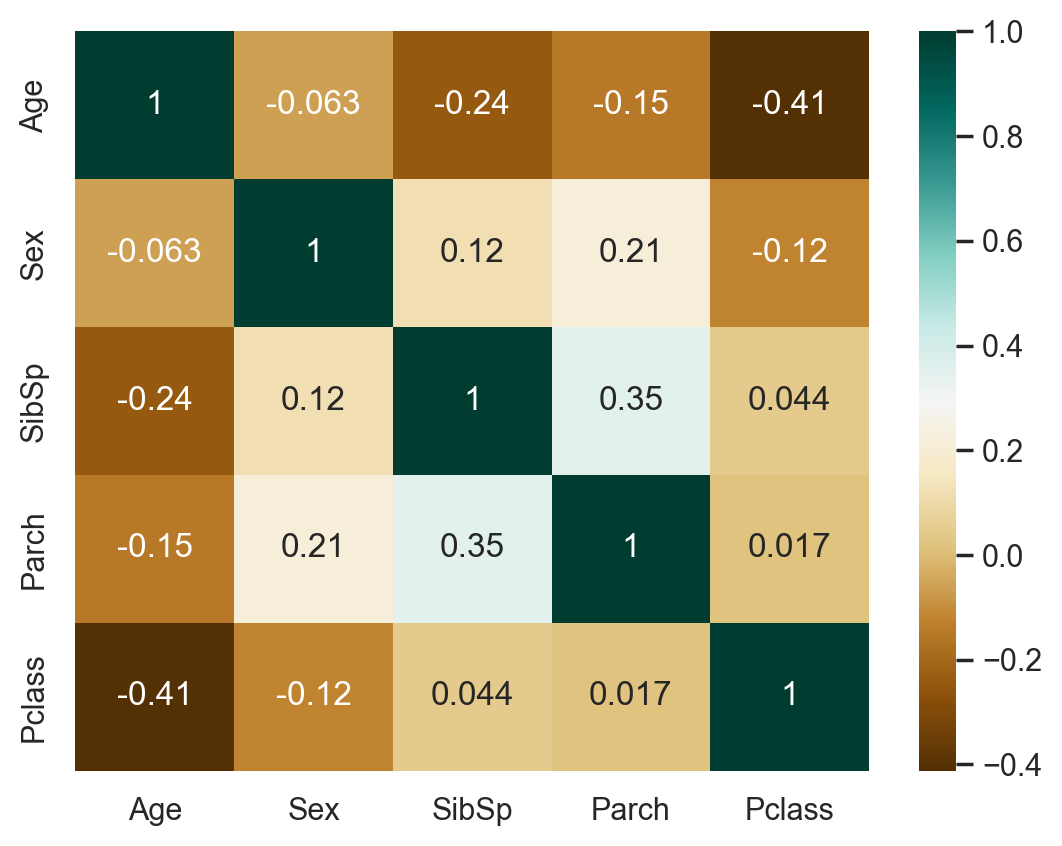

In [133]:
g = sns.heatmap(dataset[['Age', 'Sex', 'SibSp', 'Parch', 'Pclass']].corr(), cmap = 'BrBG', annot = True)

In [134]:
# Filling missing value of Age

## Fill Agen with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age:
    age_med = dataset['Age'].median()
    age_pred = dataset['Age'][((dataset['SibSp'] == dataset.iloc[i]['SibSp']) & (dataset['Parch'] == dataset.iloc[i]['Parch']) & (dataset['Pclass'] == dataset.iloc[i]['Pclass']))].median()
    if not np.isnan(age_pred):
        dataset['Age'].iloc[i] = age_pred
    else:
        dataset['Age'].iloc[i] = age_med

/var/folders/b9/d_8nll_s47g6w2x0spndwwl80000gn/T/ipykernel_28272/866625142.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
/var/folders/b9/d_8nll_s47g6w2x0spndwwl80000gn/T/ipykernel_28272/866625142.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
/var/folders/b9/d_8nll_s47g6w2x0spndwwl80000gn/T/ipykernel_28272/866625142.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

In [135]:
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1007
Embarked          0
dtype: int64

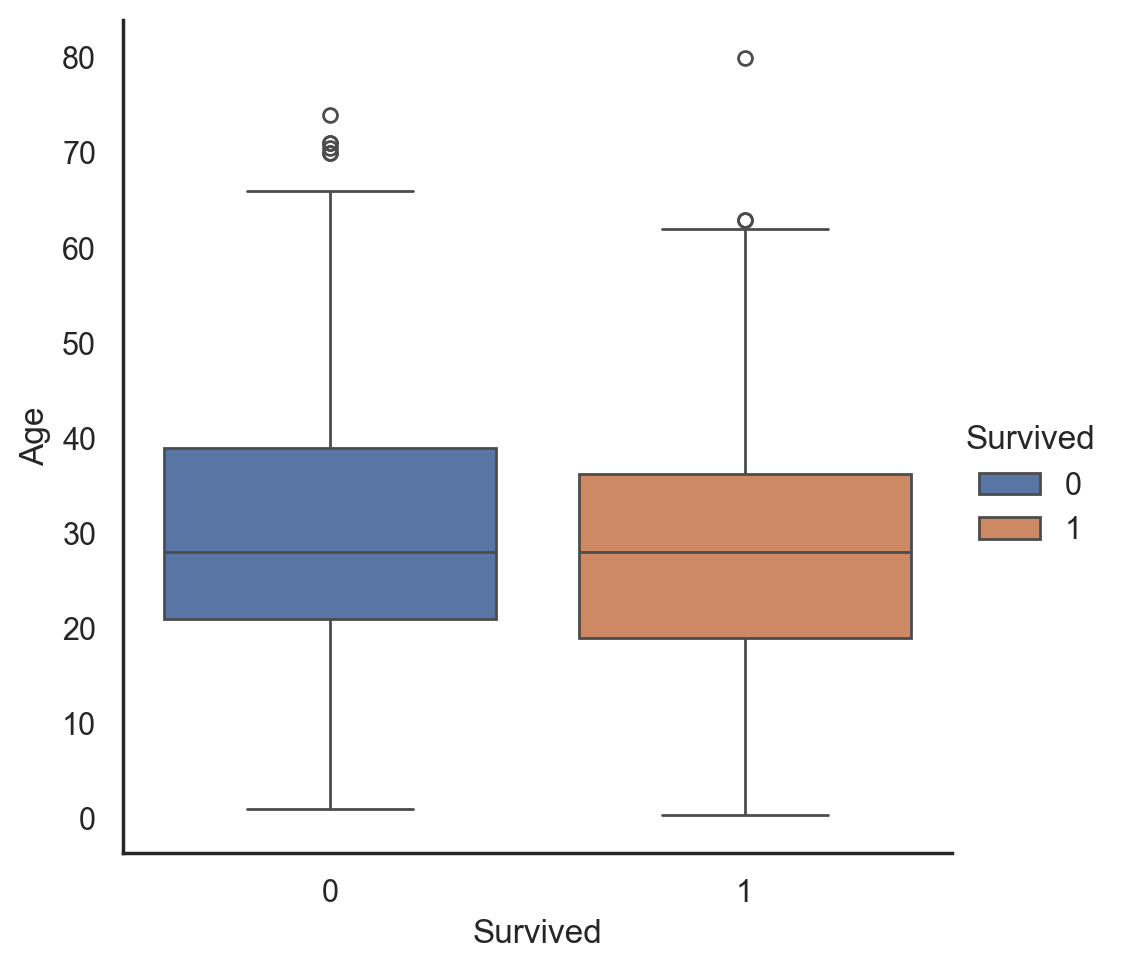

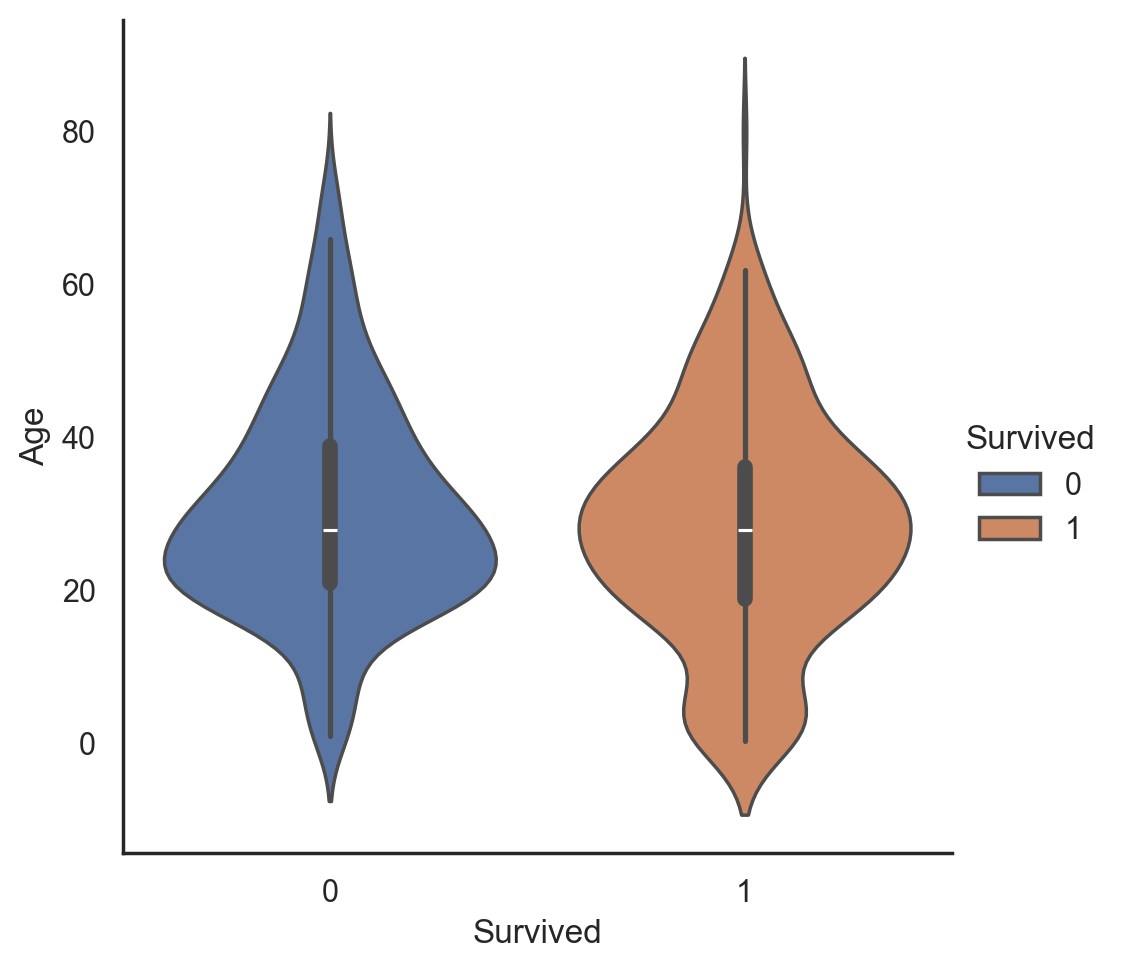

In [136]:
g = sns.catplot(x = 'Survived', y = 'Age', data = train, kind = 'box', hue = 'Survived')
g = sns.catplot(x = 'Survived', y = 'Age', data = train, kind = 'violin', hue = 'Survived')

## 5. Feature engineering

###  5.1 Name/Title

In [137]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [138]:
# Get Title from Name
dataset_title = [i.split(',')[1].split('.')[0].strip() for i in dataset['Name']]
dataset['Title'] = pd.Series(dataset_title)
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

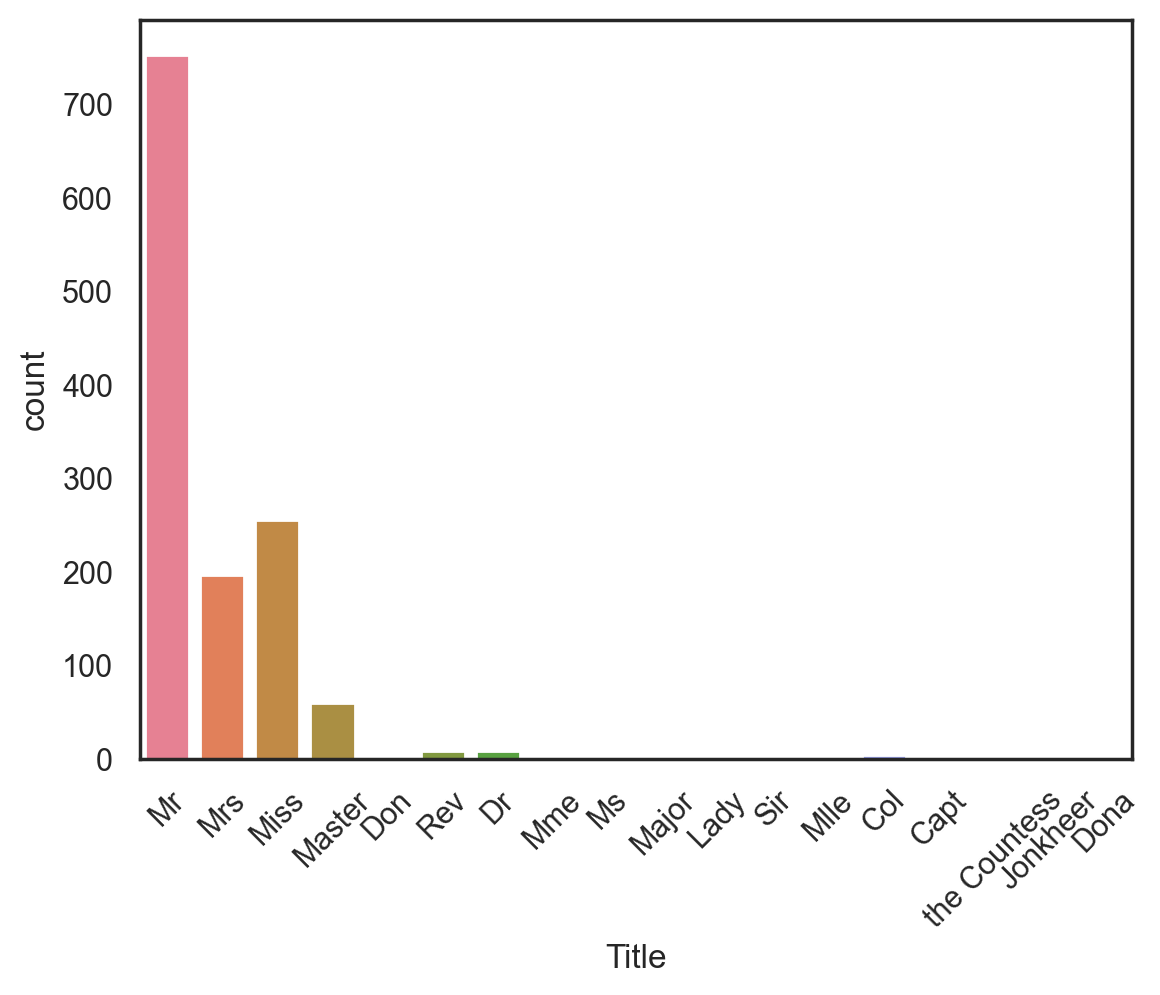

In [139]:
g = sns.countplot(x = 'Title', data = dataset, hue = 'Title')
g = plt.setp(g.get_xticklabels(), rotation = 45)

In [140]:
dataset['Title'].value_counts(1)

Title
Mr              0.579677
Miss            0.196305
Mrs             0.151655
Master          0.046189
Rev             0.006159
Dr              0.006159
Col             0.003079
Mlle            0.001540
Major           0.001540
Ms              0.001540
Lady            0.000770
Sir             0.000770
Mme             0.000770
Don             0.000770
Capt            0.000770
the Countess    0.000770
Jonkheer        0.000770
Dona            0.000770
Name: proportion, dtype: float64

In [141]:
dataset['Title'].isnull().sum()

0

In [142]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].fillna(-1).astype(int)


In [143]:
dataset['Title'].value_counts()

Title
2    753
1    457
0     60
3     29
Name: count, dtype: int64

/var/folders/b9/d_8nll_s47g6w2x0spndwwl80000gn/T/ipykernel_28272/4028554351.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='Title', data=dataset, kind='count', palette='muted')


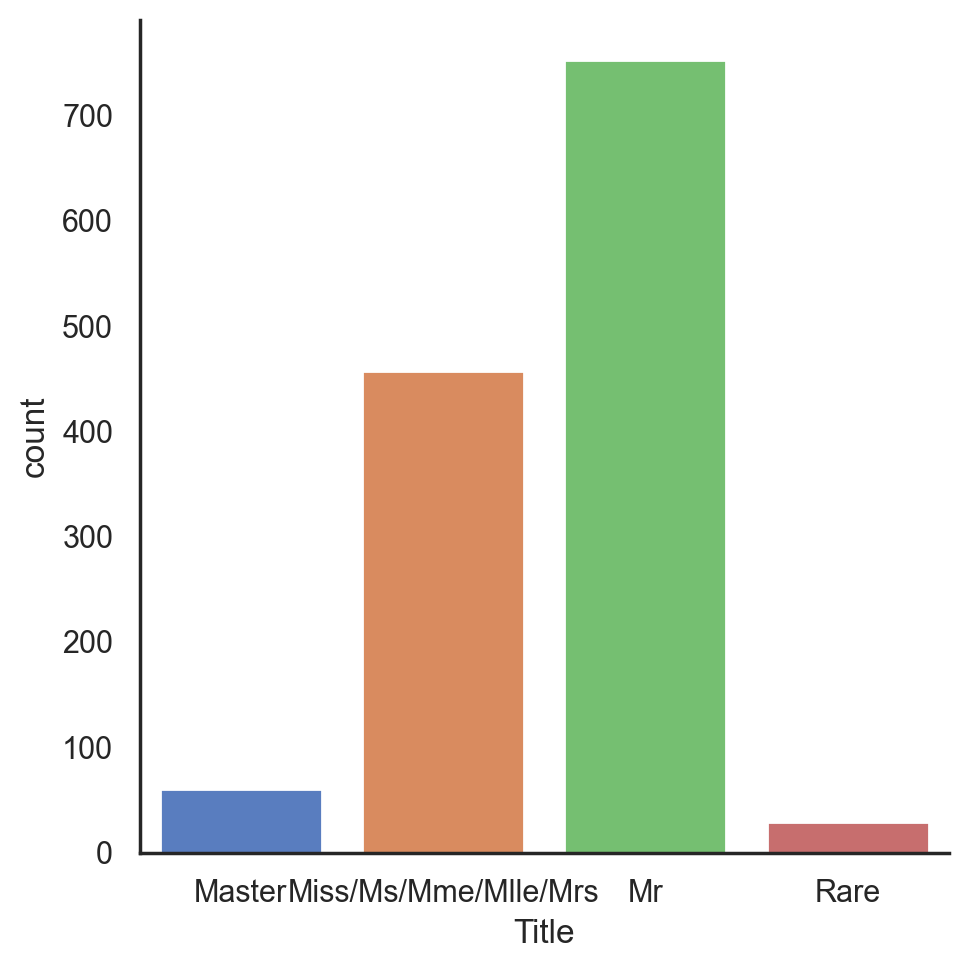

In [144]:
g = sns.catplot(x='Title', data=dataset, kind='count', palette='muted')
g = g.set_xticklabels(['Master', 'Miss/Ms/Mme/Mlle/Mrs', 'Mr', 'Rare'])


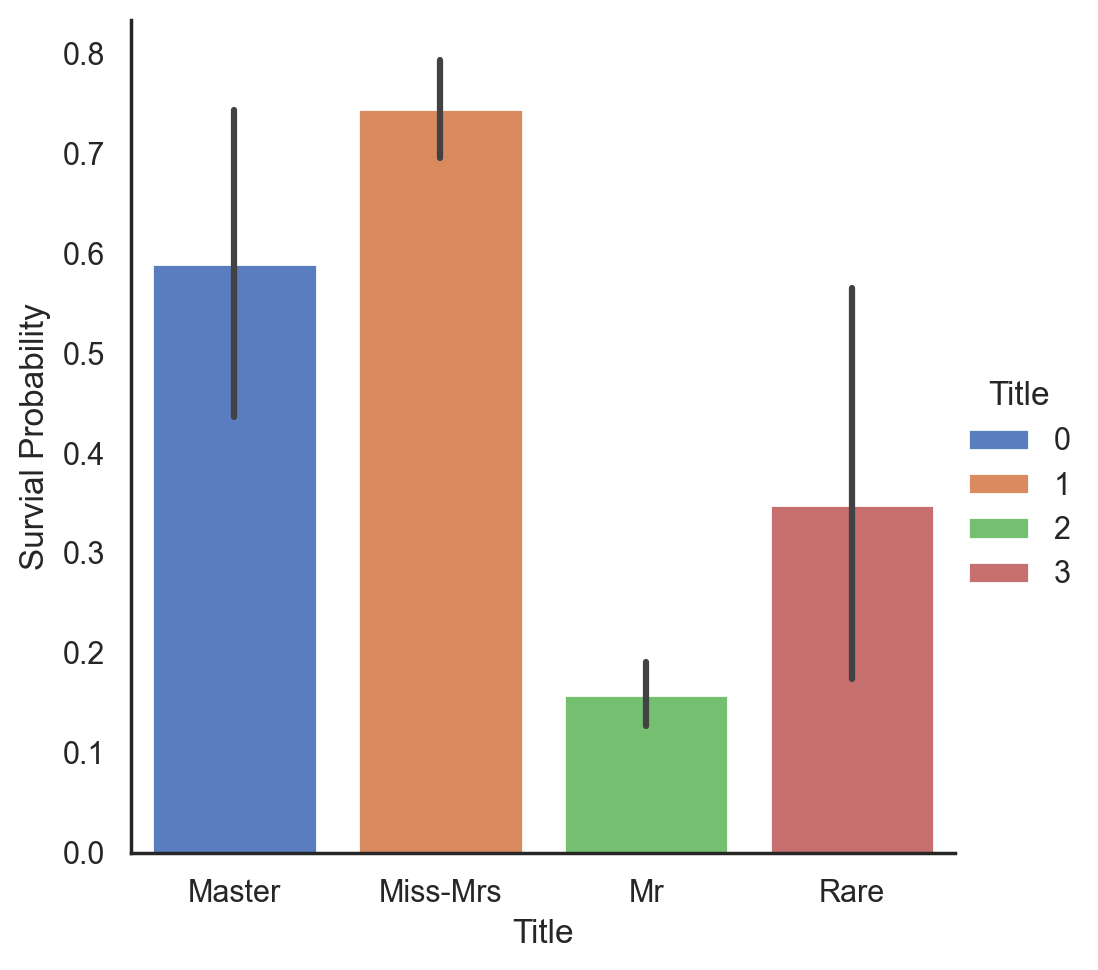

In [145]:
g = sns.catplot(x = 'Title', y = 'Survived', data = dataset, kind = 'bar', hue = 'Title', palette = 'muted')
g = g.set_xticklabels(['Master', 'Miss-Mrs', 'Mr', 'Rare'])
g = g.set_ylabels('Survial Probability')

In [146]:
# Drop Name variable
dataset.drop(labels = ['Name'], axis = 1, inplace = True)

### 5.2 Family size

In [147]:
# Create a family size descriptor from SibSp and Parch
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

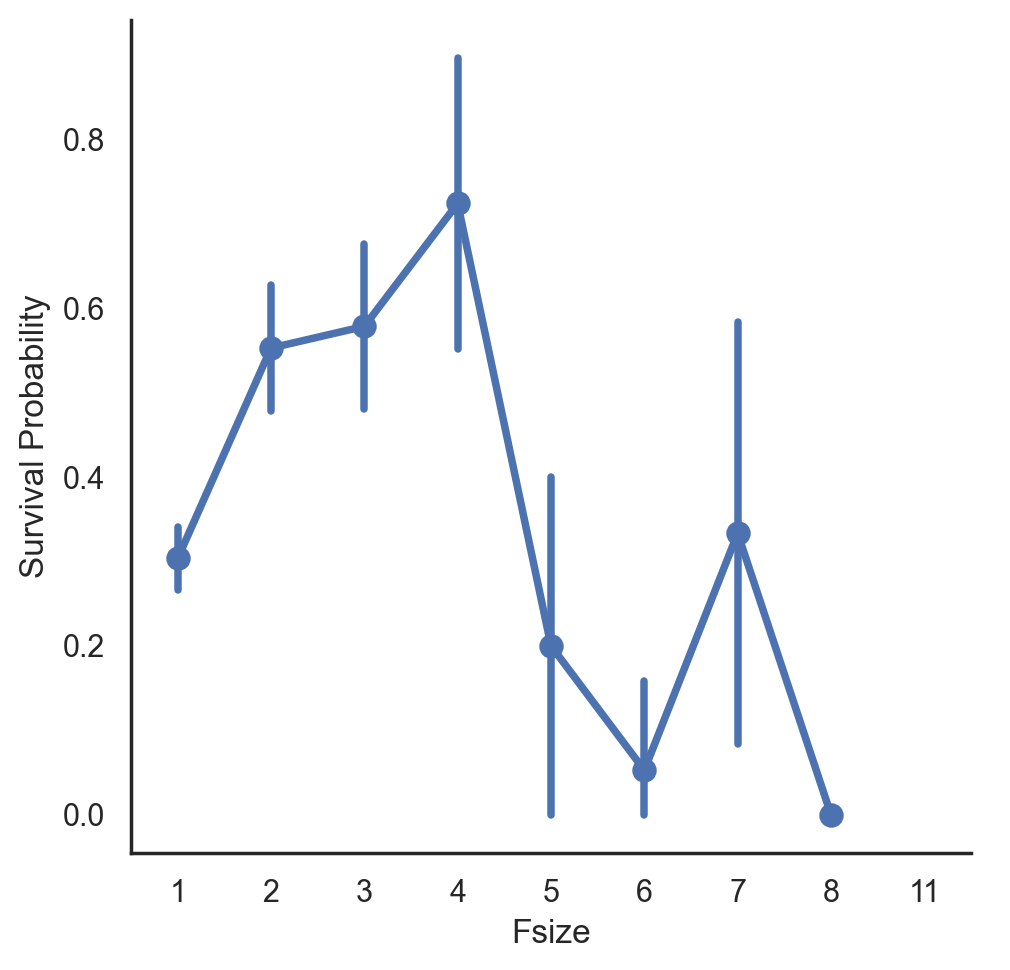

In [148]:
g = sns.catplot(x = 'Fsize', y = 'Survived', data = dataset, kind = 'point')
g = g.set_ylabels('Survival Probability')

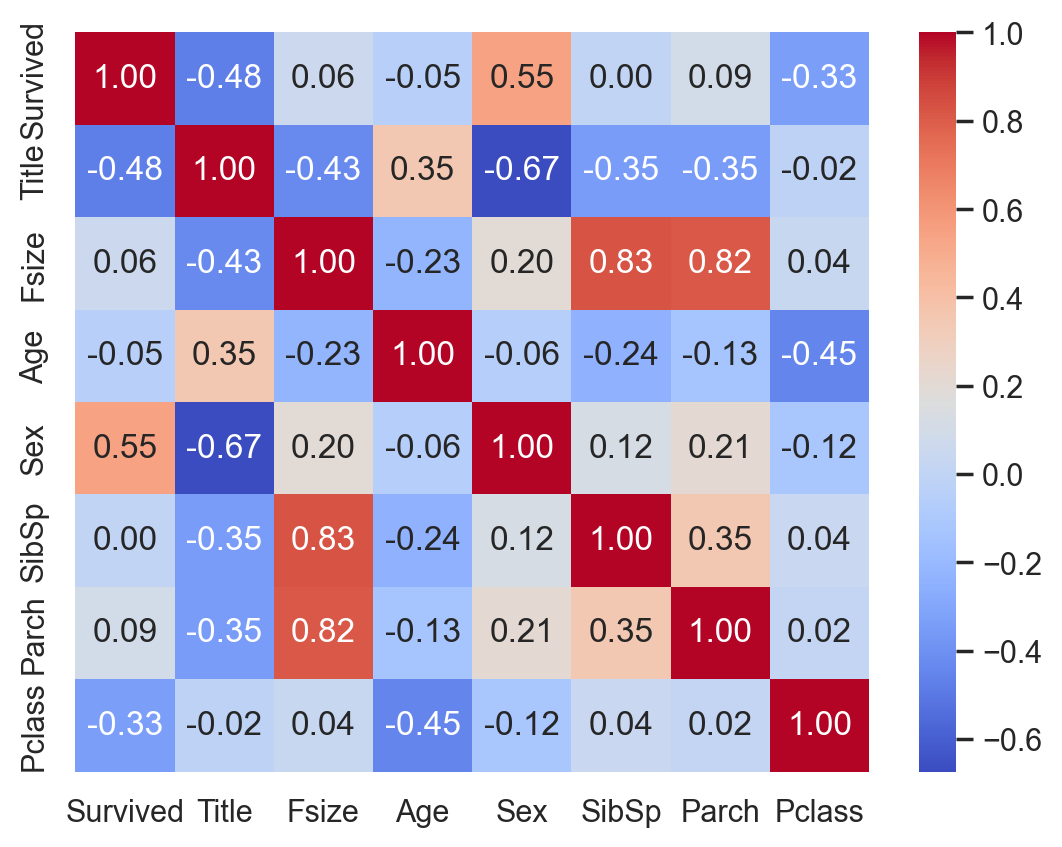

In [149]:
g = sns.heatmap(dataset[['Survived', 'Title', 'Fsize', 'Age', 'Sex', 'SibSp', 'Parch', 'Pclass']].corr(), annot = True, fmt = '.2f', cmap = 'coolwarm')


In [150]:
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if s == 2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

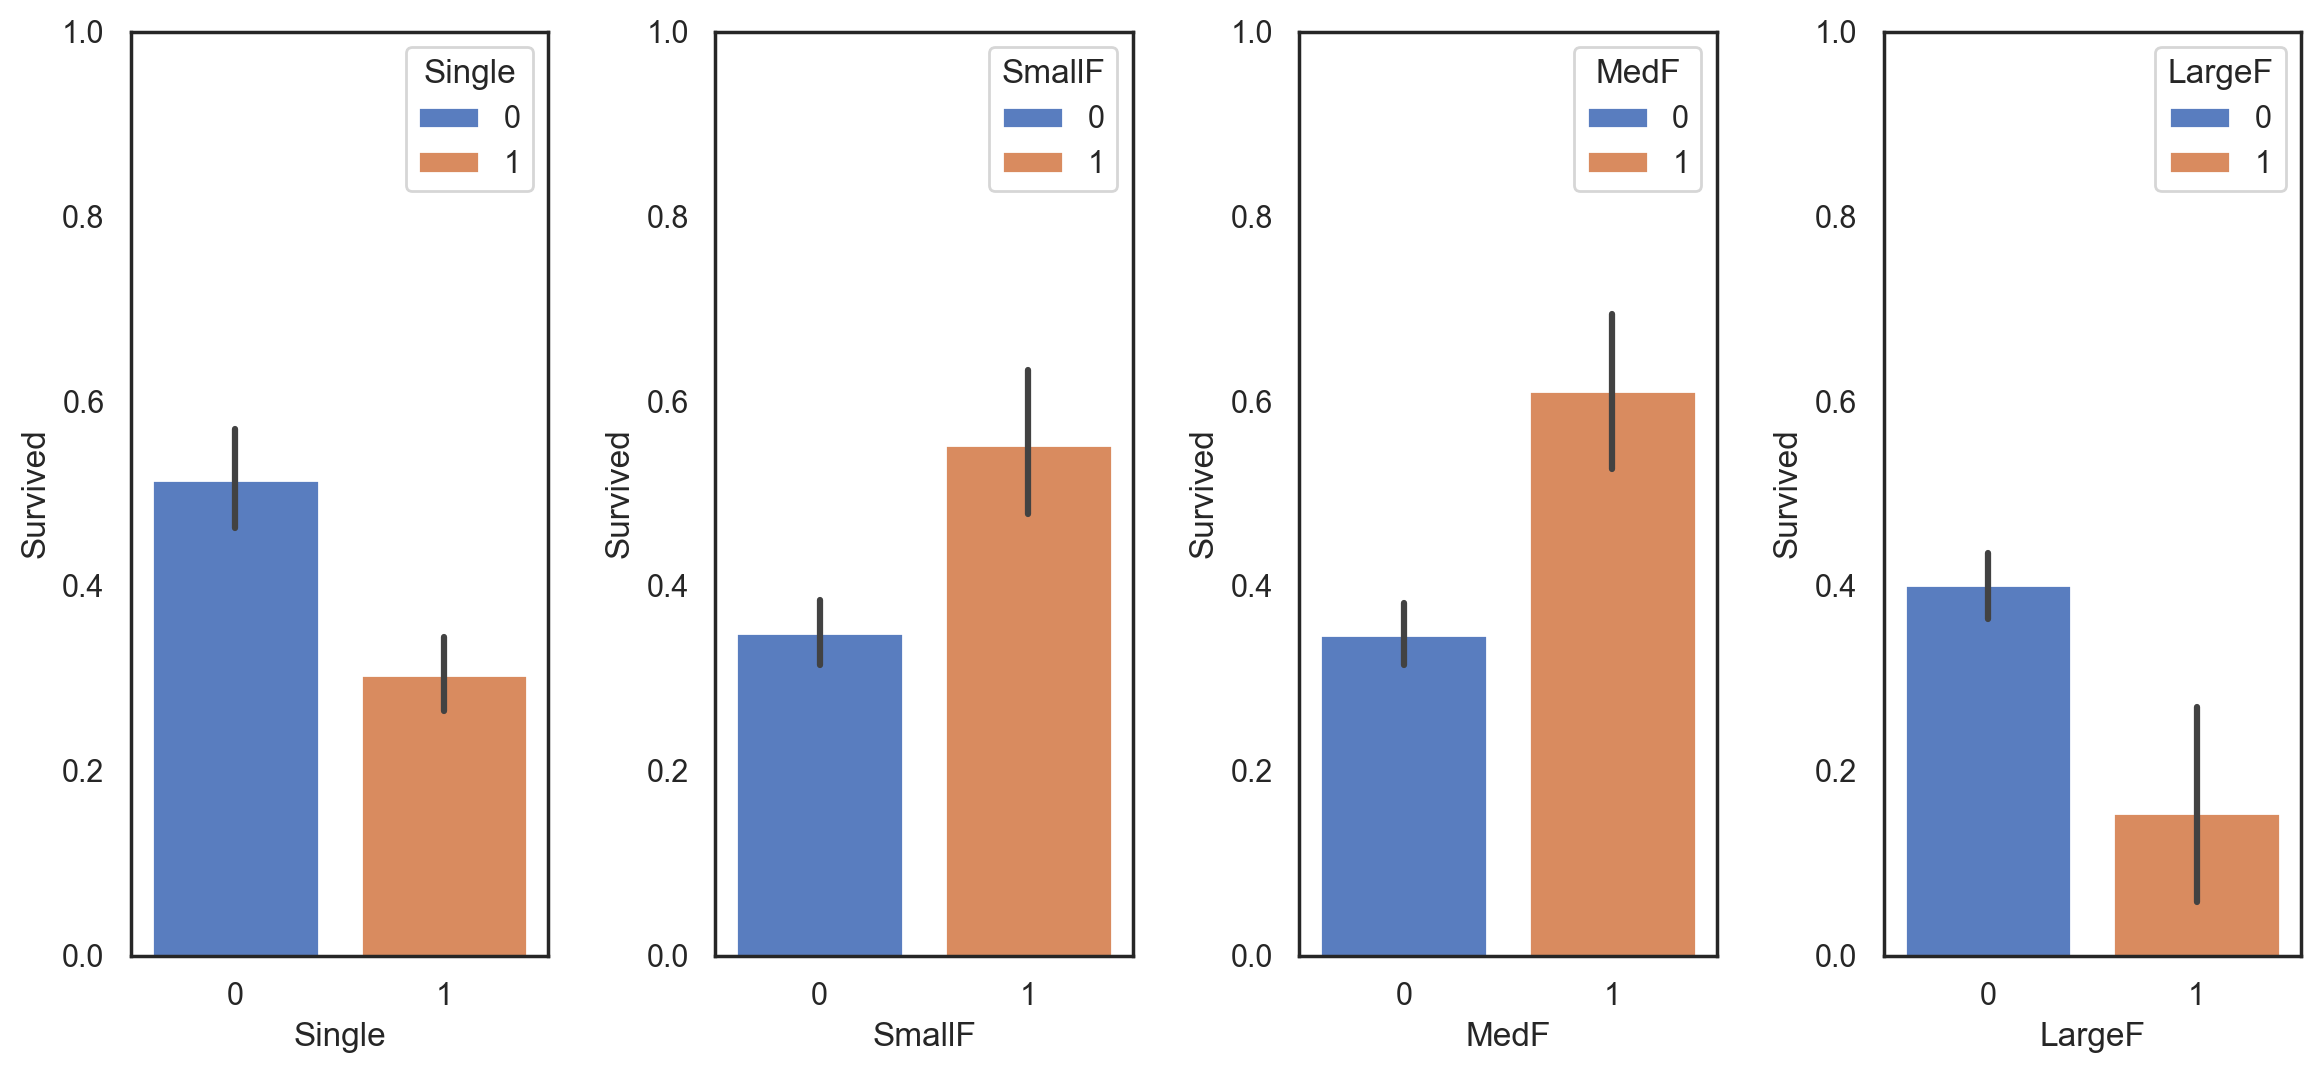

In [151]:
f, ax = plt.subplots(1, 4, figsize = (14, 6))

sns.barplot(x = 'Single', y = 'Survived', data = dataset, hue = 'Single', palette = 'muted', ax = ax[0])
sns.barplot(x = 'SmallF', y = 'Survived', data = dataset, hue = 'SmallF', palette = 'muted', ax = ax[1])
sns.barplot(x = 'MedF', y = 'Survived', data = dataset, hue = 'MedF', palette = 'muted', ax = ax[2])
sns.barplot(x = 'LargeF', y = 'Survived', data = dataset, hue = 'LargeF', palette = 'muted', ax = ax[3])
ax[0].set_ylim(0, 1)
ax[1].set_ylim(0, 1)
ax[2].set_ylim(0, 1)
ax[3].set_ylim(0, 1)
plt.subplots_adjust(wspace = 0.4)


In [152]:
# Convert to indicator values Title and Embarked
dataset[['Title', 'Embarked']]

,Title,Embarked
0,2,S
1,1,C
2,1,S
3,1,S
4,2,S
...,...,...
1294,2,S
1295,3,C
1296,2,S
1297,2,S


In [153]:
dataset = pd.get_dummies(dataset, columns = ['Title'])
dataset = pd.get_dummies(dataset, columns = ['Embarked'], prefix = 'Em')

In [154]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,False,False,True,False,False,False,True
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,False,True,False,False,True,False,False
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,False,True,False,False,False,False,True
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,False,True,False,False,False,False,True
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,False,False,True,False,False,False,True


### 5.3 Cabin

In [155]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [156]:
dataset['Cabin'].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [157]:
dataset['Cabin'].isnull().sum()

1007

In [158]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [159]:
# Replace the Cain number by the type of cabin 'X' if not
dataset['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

In [160]:
dataset['Cabin'].value_counts()

Cabin
X    1007
C      91
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: count, dtype: int64

<Axes: xlabel='Cabin', ylabel='count'>

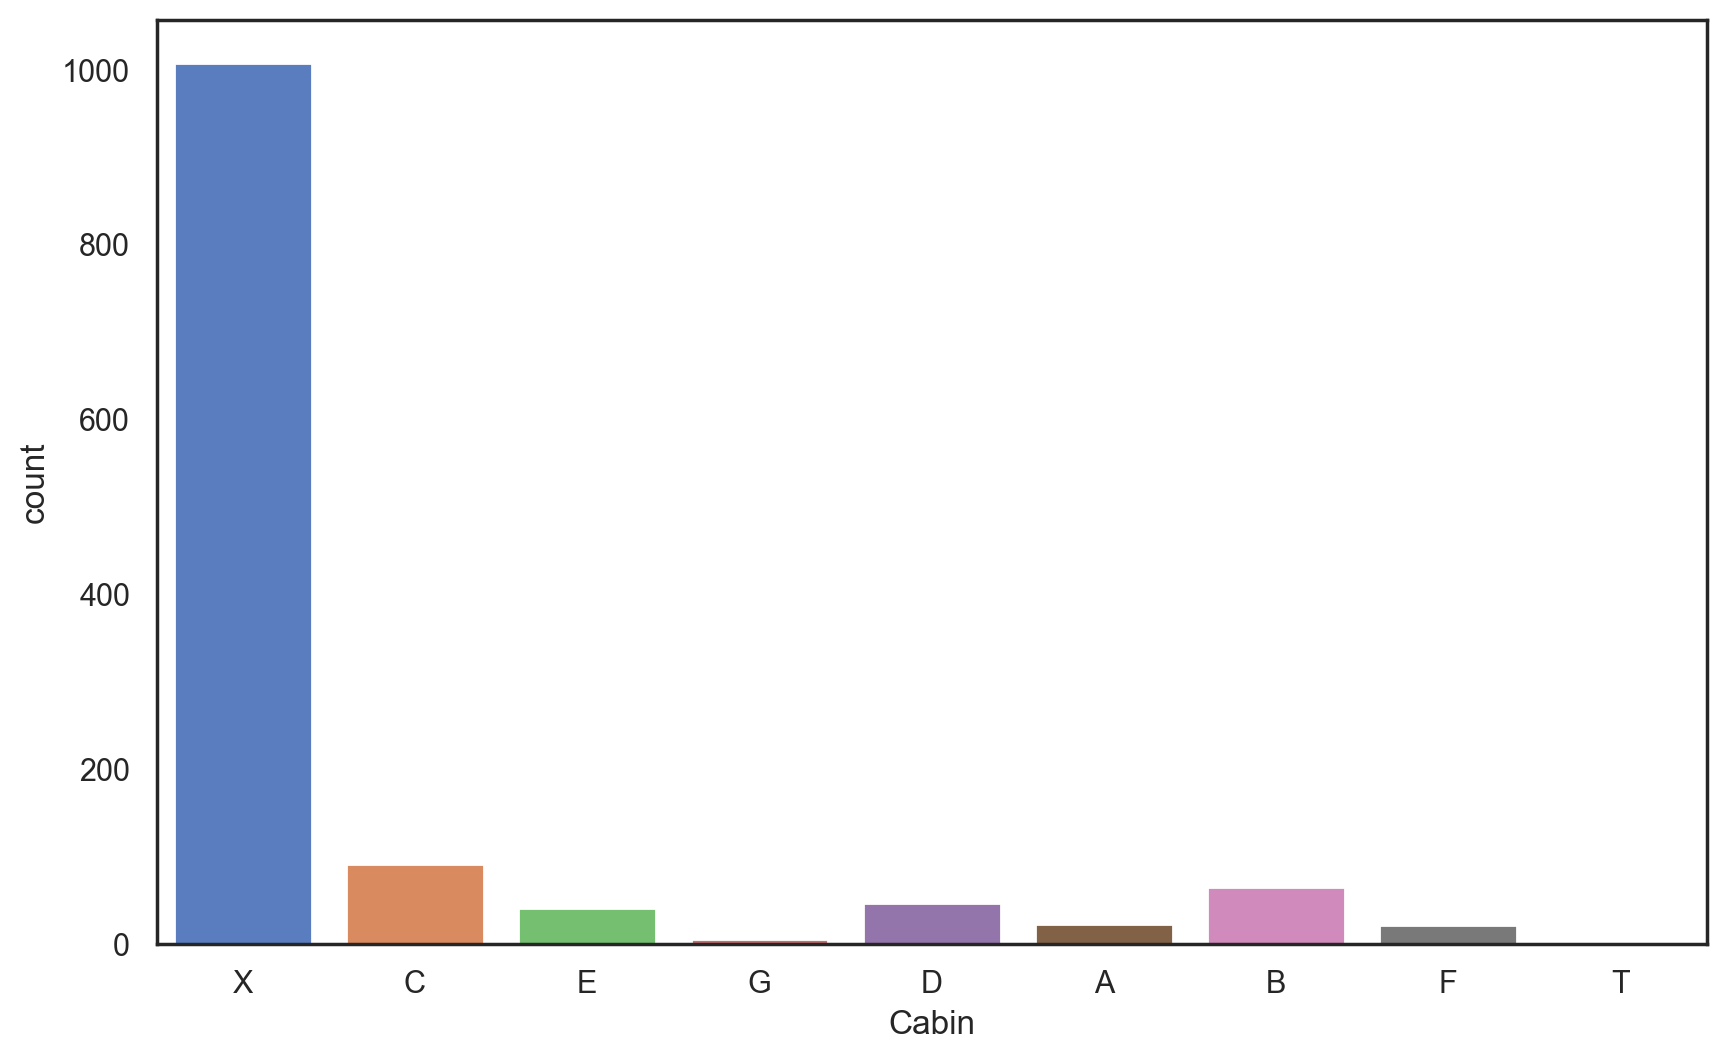

In [161]:
f, ax = plt.subplots(1, 1, figsize = (10, 6))
sns.countplot(x = 'Cabin', data = dataset, hue = 'Cabin', palette = 'muted')

Text(0, 0.5, 'Survival Probability')

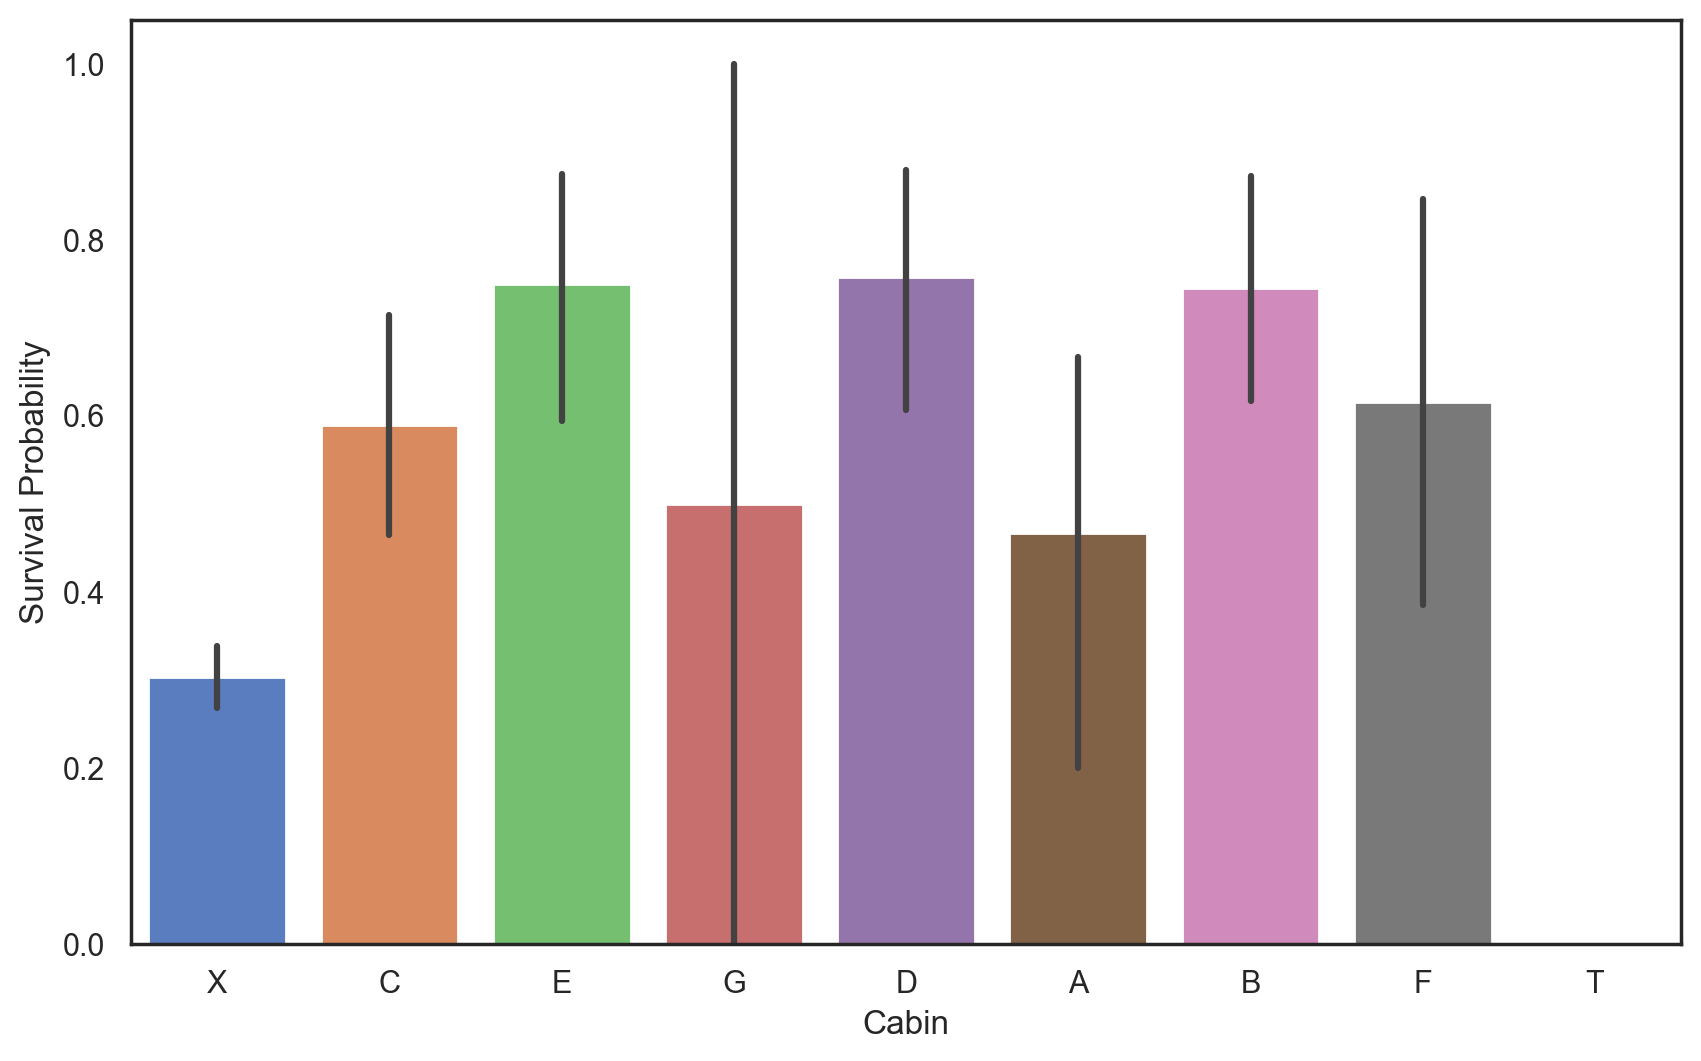

In [162]:
f, ax = plt.subplots(1, 1, figsize = (10, 6))
sns.barplot(x = 'Cabin', y = 'Survived', data = dataset, hue = 'Cabin', palette = 'muted', ax = ax)
ax.set_ylabel('Survival Probability')


In [163]:
dataset = pd.get_dummies(dataset, columns = ['Cabin'], prefix = 'Cabin')

### 5.4 Ticket

In [164]:
dataset['Ticket'].value_counts()

Ticket
CA 2144         8
1601            8
3101295         7
S.O.C. 14879    7
PC 17608        7
               ..
113792          1
36209           1
323592          1
315089          1
359309          1
Name: count, Length: 929, dtype: int64

In [165]:
dataset['Ticket'].describe()

count        1299
unique        929
top       CA 2144
freq            8
Name: Ticket, dtype: object

In [166]:
## Treat ticket by extracting the ticket prefix. When there is no prefix it returns X.
Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace('.', '').replace('/', '').strip().split(' ')[0])
    else:
        Ticket.append('X')

dataset['Ticket'] = Ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [167]:
dataset['Ticket'].unique()

array(['A5', 'PC', 'STONO2', 'X', 'PP', 'CA', 'SCParis', 'SCA4', 'A4',
       'SP', 'SOC', 'WC', 'SOTONOQ', 'WEP', 'STONO', 'C', 'SCPARIS',
       'SOP', 'Fa', 'LINE', 'FCC', 'SWPP', 'SCOW', 'PPP', 'SC', 'SCAH',
       'AS', 'SOPP', 'FC', 'SOTONO2', 'CASOTON', 'SCA3', 'STONOQ', 'AQ4',
       'A', 'LP', 'AQ3'], dtype=object)

In [168]:
dataset = pd.get_dummies(dataset, columns = ['Ticket'], prefix = 'T')

In [169]:
dataset['Pclass'].value_counts()

Pclass
3    702
1    320
2    277
Name: count, dtype: int64

In [170]:
# Create catergorical values for Pclass
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns = ['Pclass'], prefix = 'Pc')

In [171]:
dataset.head()

,PassengerId,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,1,0.0,0,22.0,1,0,1.981001,2,0,1,...,False,False,False,False,False,False,False,False,False,True
1,2,1.0,1,38.0,1,0,4.266662,2,0,1,...,False,False,False,False,False,False,False,True,False,False
2,3,1.0,1,26.0,0,0,2.070022,1,1,0,...,False,True,False,False,False,False,False,False,False,True
3,4,1.0,1,35.0,1,0,3.972177,2,0,1,...,False,False,False,False,False,False,True,True,False,False
4,5,0.0,0,35.0,0,0,2.085672,1,1,0,...,False,False,False,False,False,False,True,False,False,True


## 6. Modeling

In [172]:
len(dataset)

1299

In [173]:
train_len

881

In [174]:
## Separate train dataset and test dataset
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels = ['Survived'], axis = 1, inplace = True)

/var/folders/b9/d_8nll_s47g6w2x0spndwwl80000gn/T/ipykernel_28272/3016624512.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(labels = ['Survived'], axis = 1, inplace = True)


In [175]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 68 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    float64
 2   Sex          881 non-null    int64  
 3   Age          881 non-null    float64
 4   SibSp        881 non-null    int64  
 5   Parch        881 non-null    int64  
 6   Fare         881 non-null    float64
 7   Fsize        881 non-null    int64  
 8   Single       881 non-null    int64  
 9   SmallF       881 non-null    int64  
 10  MedF         881 non-null    int64  
 11  LargeF       881 non-null    int64  
 12  Title_0      881 non-null    bool   
 13  Title_1      881 non-null    bool   
 14  Title_2      881 non-null    bool   
 15  Title_3      881 non-null    bool   
 16  Em_C         881 non-null    bool   
 17  Em_Q         881 non-null    bool   
 18  Em_S         881 non-null    bool   
 19  Cabin_A 

In [176]:
## Separate train feature and lable
train['Survived'] = train['Survived'].astype(int)
Y_train = train['Survived']
X_train = train.drop(labels = ['Survived'], axis = 1)


/var/folders/b9/d_8nll_s47g6w2x0spndwwl80000gn/T/ipykernel_28272/1440241917.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Survived'] = train['Survived'].astype(int)


### 6.1 Simple modeling 

#### 6.1.1 Cross validate models

In [177]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits = 10)

/Users/kenny_jung/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kenny_jung/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kenny_jung/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the

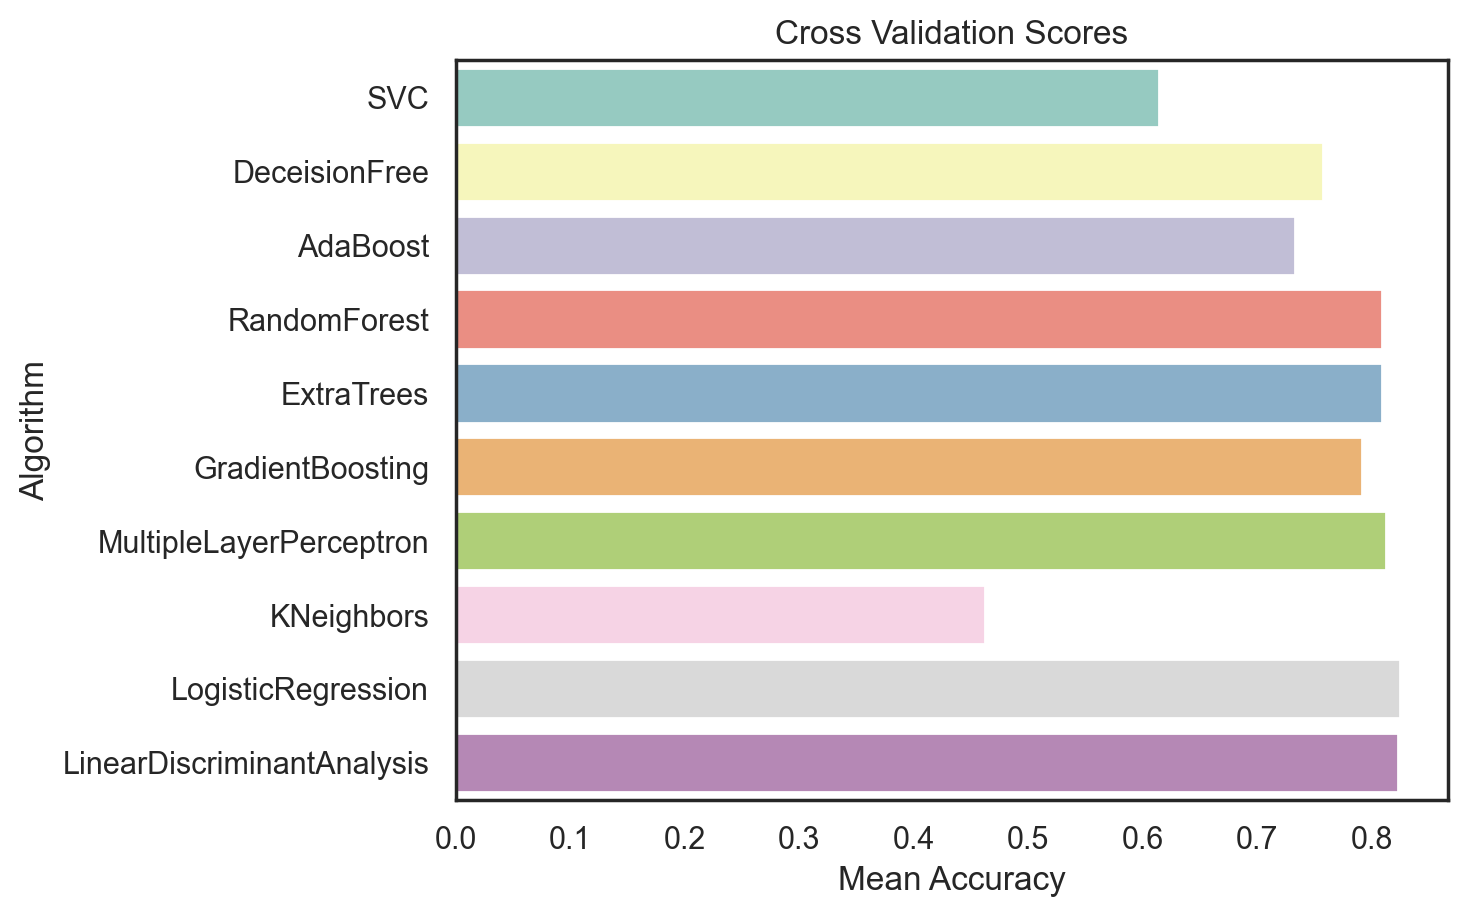

In [189]:
# Modeling step Test differents algorithms
random_state = 2
classifiers = []
classifiers.append(SVC(random_state = random_state))
classifiers.append(DecisionTreeClassifier(random_state = random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state = random_state), random_state = random_state, learning_rate = 0.1))
classifiers.append(RandomForestClassifier(random_state = random_state))
classifiers.append(ExtraTreesClassifier(random_state = random_state))
classifiers.append(GradientBoostingClassifier(random_state = random_state))
classifiers.append(MLPClassifier(random_state = random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = 'accuracy', cv = kfold, n_jobs = 4))

cv_means = []
cv_std =[]
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({'CrossValMeans': cv_means, 'CrossValerrors': cv_std, 'Algorithm': ['SVC', 'DeceisionFree', 'AdaBoost', 'RandomForest', 'ExtraTrees', 'GradientBoosting', 'MultipleLayerPerceptron', 'KNeighbors', 'LogisticRegression', 'LinearDiscriminantAnalysis']})

g = sns.barplot(x = 'CrossValMeans', y = 'Algorithm', data = cv_res, palette = 'Set3', orient = 'h')
# g = sns.barplot(x = 'CrossValMeans', y = 'Algorithm', data = cv_res, palette = 'Set3', orient = 'h', **{'xerr':cv_std})
g.set_xlabel('Mean Accuracy')
g = g.set_title('Cross Validation Scores')



In [185]:
cv_std

[0.0013023493360571849,
 0.08385505712191643,
 0.08568569161018519,
 0.04567509452280885,
 0.04411399520157446,
 0.08339073417832751,
 0.045811172362152736,
 0.08173385435219242,
 0.026052334391654306,
 0.03875071097250674]

### 6.1.2 Hyperparameter tunning for best models

In [197]:
### META Modeling with AdaBoost, RF, ExtraTrees, and GradientBoosting

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state = 7)

ada_param_grid = {'base_estimator__criterion': ['gini', 'entropy'],
                  'base_estimator__splitter': ['best', 'random'],
                  'algorithm': ['SAMME', 'SAMME.R'],
                  'n_estimators': [1, 2],
                  'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]}

gsadaDTC = GridSearchCV(adaDTC, param_grid = ada_param_grid, cv = kfold, scoring = 'accuracy', n_jobs = 10, verbose = 1)

gsadaDTC.fit(X_train, Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


/Users/kenny_jung/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/kenny_jung/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/kenny_jung/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/ken

In [198]:
gsadaDTC.best_score_

0.7753192032686415

In [199]:
# ExtraTrees

ExtC = ExtraTreesClassifier()

## Search grid for optimal parameters
ex_param_grid = {'max_depth': [None],
                 'max_features': [1, 3, 10],
                 'min_samples_split': [2, 3, 10],
                 'min_samples_leaf': [1, 3, 10],
                 'bootstrap': [False],
                 'n_estimators': [100, 300],
                 'criterion': ['gini']}

gsExtC = GridSearchCV(ExtC, param_grid = ex_param_grid, cv = kfold, scoring = 'accuracy', n_jobs = 10, verbose =1)

gsExtC.fit(X_train, Y_train)

ExtC_best = gsExtC.best_estimator_

# Best Score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8331332992849847

In [202]:
# RFC Parameters tunning
RFC = RandomForestClassifier()

## Search grid for optimal parameters
rf_param_grid = {'max_depth': [None],
                 'max_features': [1, 3, 10],
                 'min_samples_split': [2, 3, 10],
                 'min_samples_leaf': [1, 3, 10],
                 'bootstrap': [False],
                 'n_estimators': [100, 300],
                 'criterion': ['gini']}

gsRFC = GridSearchCV(RFC, param_grid = rf_param_grid, cv = kfold, scoring = 'accuracy', n_jobs = 10, verbose =1)

gsRFC.fit(X_train, Y_train)

RFC_best = gsRFC.best_estimator_

# Best Score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8331332992849847

In [209]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss': ['exponential'],  # 'deviance', 'log_loss' or 'exponential'.
                 'n_estimators': [100, 200, 300],
                 'learning_rate': [0.1, 0.05, 0.01],
                 'max_depth': [4, 8],
                 'min_samples_leaf': [100, 150],
                 'max_features': [0.3, 0.1]}

gsGBC = GridSearchCV(GBC, param_grid = gb_param_grid, cv = kfold, scoring = 'accuracy', n_jobs = 10, verbose =1)

gsGBC.fit(X_train, Y_train)

GBC_best = gsGBC.best_estimator_

# Best Score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.8115679264555669

In [211]:
### SVC classifier

SVMC = SVC(probability = True)
svc_raram_grid = {'kernel': ['rbf'],
                  'gamma': [0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100, 200, 300, 1000]}

gsSVMC = GridSearchCV(SVMC, param_grid = svc_raram_grid, cv = kfold, scoring = 'accuracy', n_jobs = 10, verbose =1)

gsSVMC.fit(X_train, Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best Score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.6140704800817159

### 6.1.3 Plot learning curves

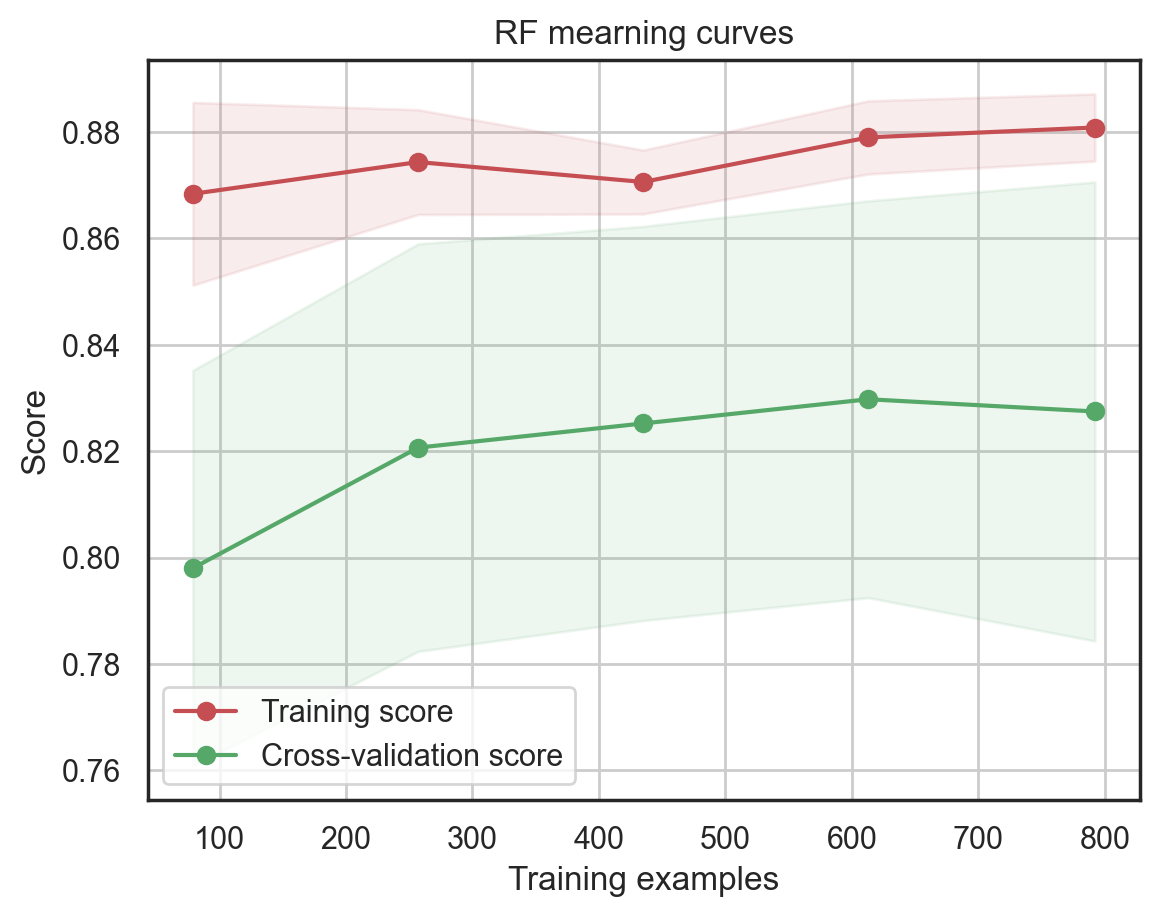

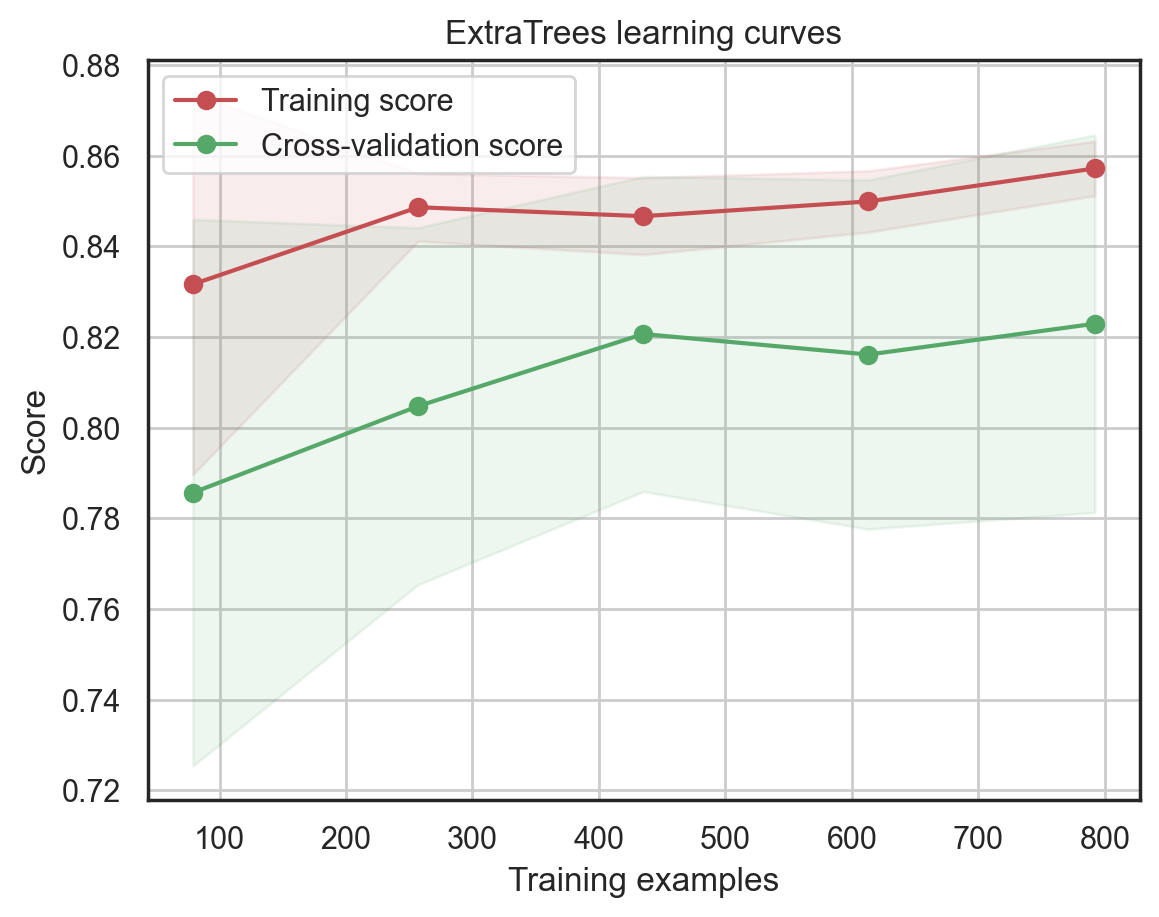

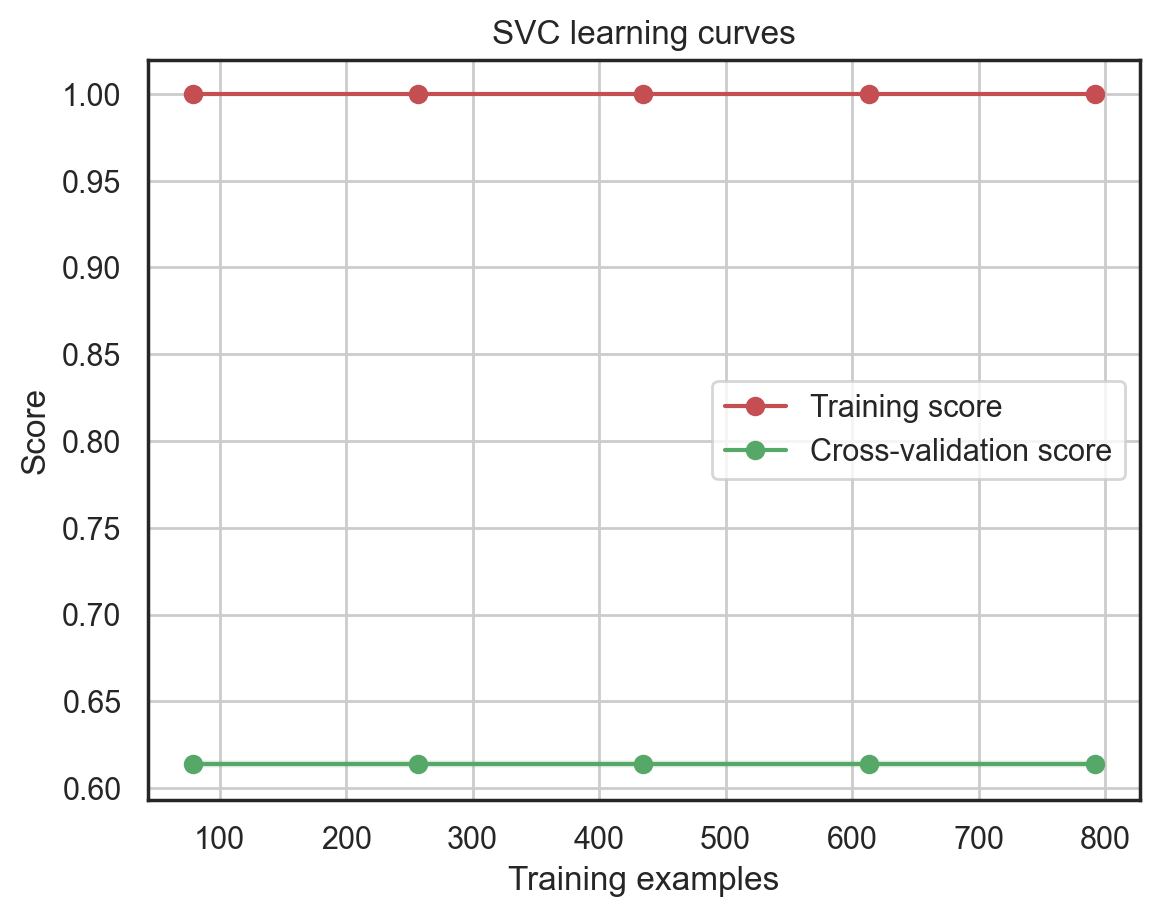

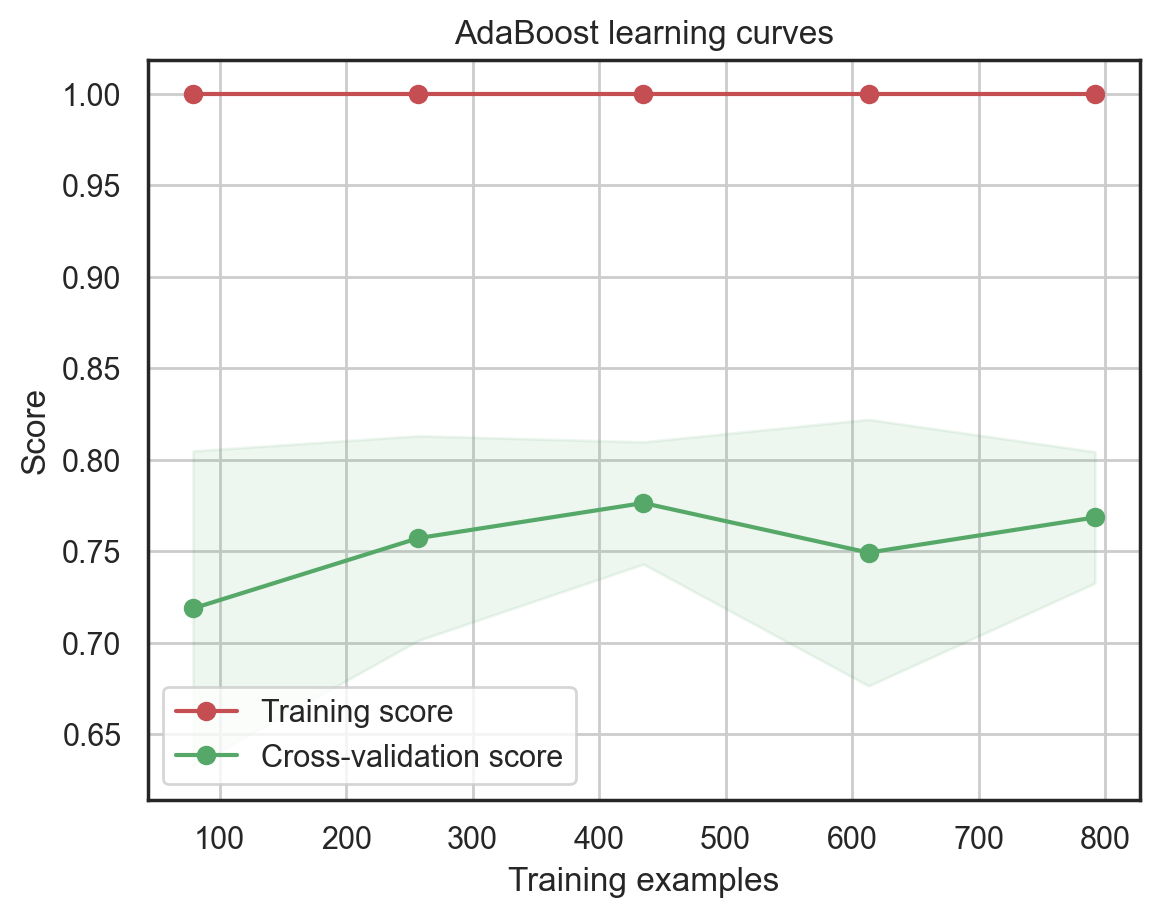

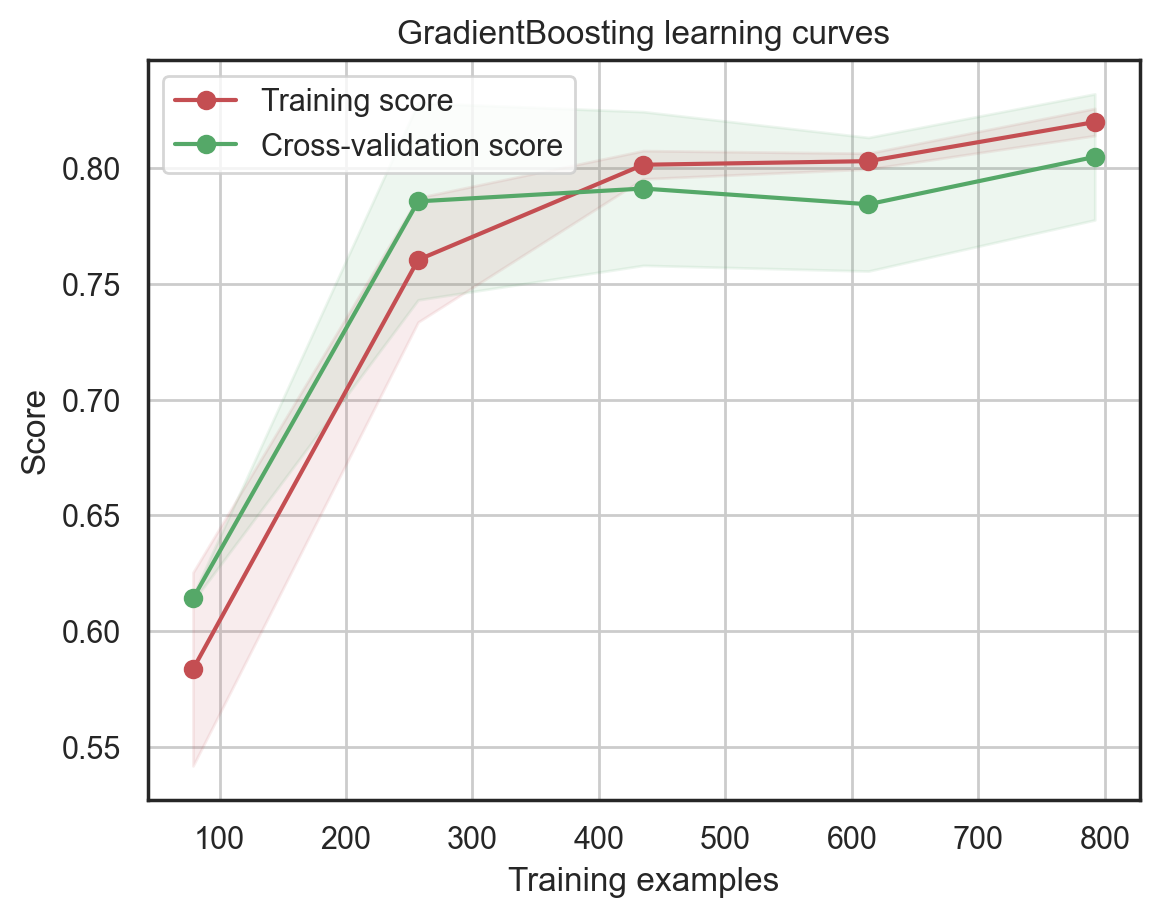

In [215]:
def plot_learning_curve(estimator, title, X, y, ylim = None, cv = None, n_jobs = -1, train_sizes = np.linspace(.1, 1.0, 5)):
    '''Generate a simple plot of the test and training leanring curve'''
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv = cv, n_jobs = n_jobs, train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis =1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis =1)
    test_scores_std = np.std(test_scores, axis =1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha = 0.1, color = 'r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha = 0.1, color ='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color = 'r', label = 'Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color = 'g', label = 'Cross-validation score')
    
    plt.legend(loc = 'best')
    return plt

g = plot_learning_curve(gsRFC.best_estimator_, 'RF mearning curves', X_train, Y_train, cv = kfold)
g = plot_learning_curve(gsExtC.best_estimator_, 'ExtraTrees learning curves', X_train, Y_train, cv = kfold)
g = plot_learning_curve(gsSVMC.best_estimator_, 'SVC learning curves', X_train, Y_train, cv = kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_, 'AdaBoost learning curves', X_train, Y_train, cv = kfold)
g = plot_learning_curve(gsGBC.best_estimator_, 'GradientBoosting learning curves', X_train, Y_train, cv = kfold)

### 6.1.4 Feature importance of tree based classifiers

/var/folders/b9/d_8nll_s47g6w2x0spndwwl80000gn/T/ipykernel_28272/1412926018.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(y = X_train.columns[indices][:40],
/var/folders/b9/d_8nll_s47g6w2x0spndwwl80000gn/T/ipykernel_28272/1412926018.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(y = X_train.columns[indices][:40],
/var/folders/b9/d_8nll_s47g6w2x0spndwwl80000gn/T/ipykernel_28272/1412926018.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(y = X_train.columns[indices][:40],
/var/folders/b9/d_8nll_s47g6w2x0spndwwl8000

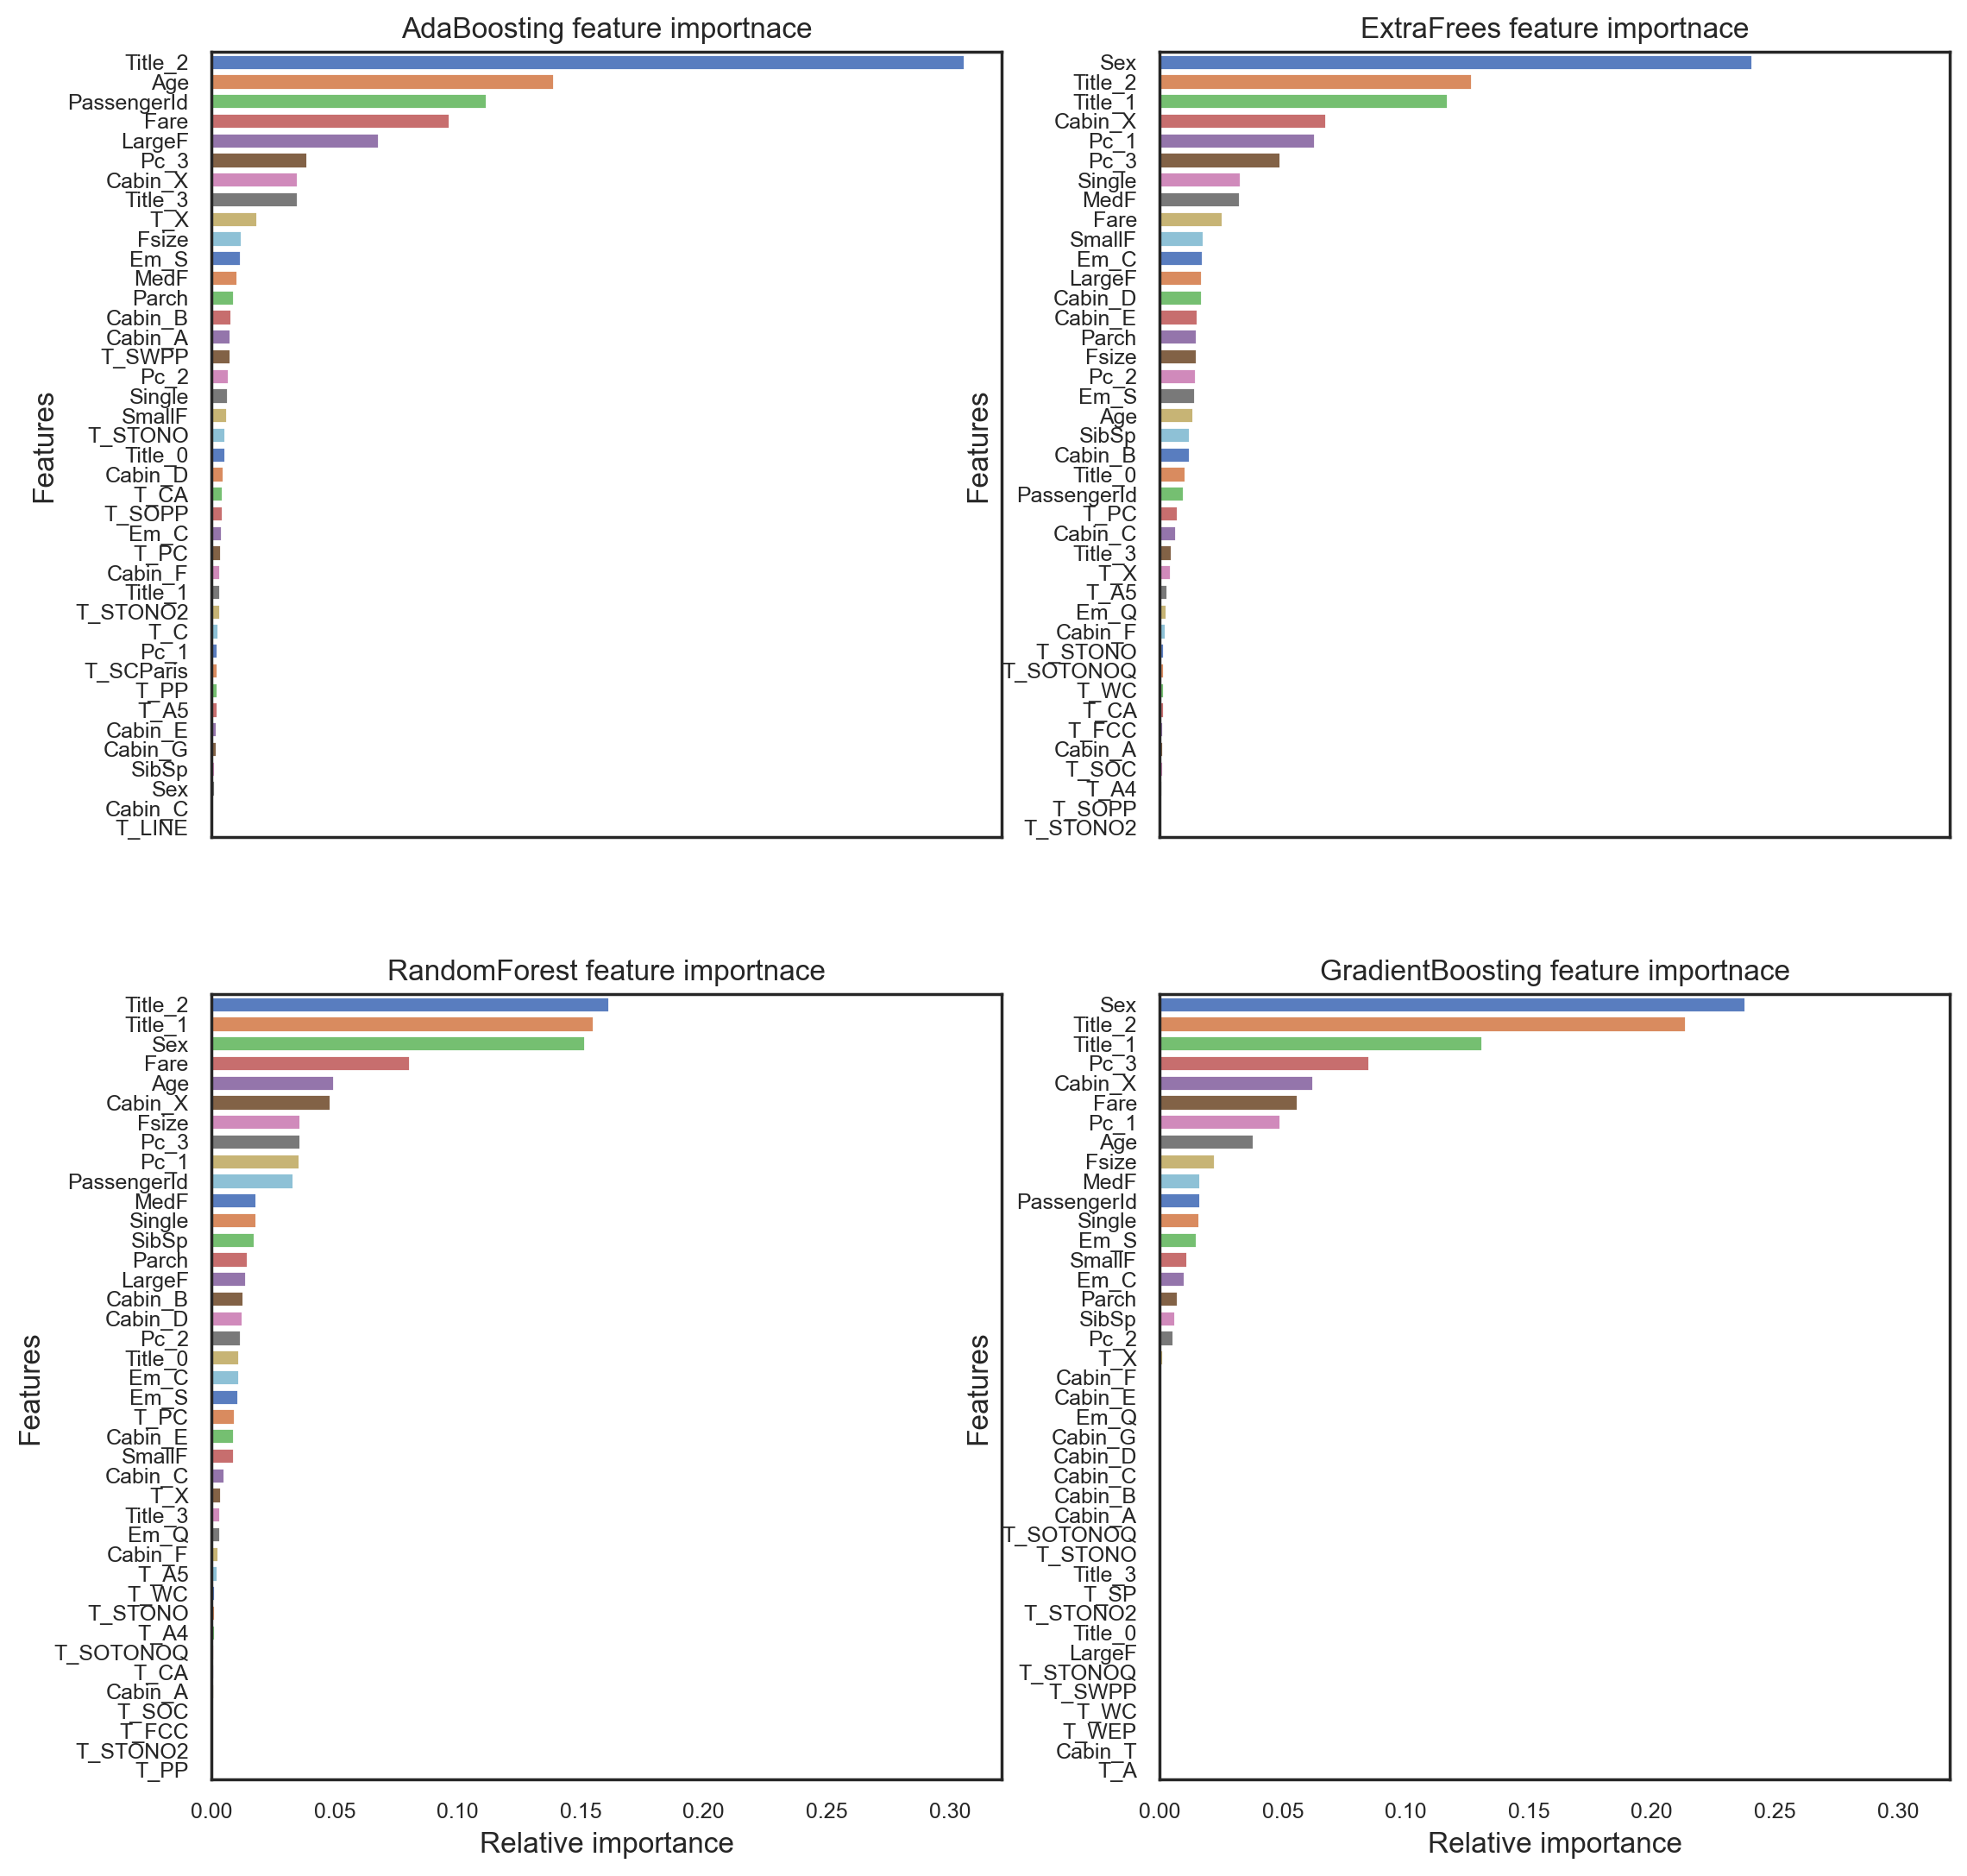

In [230]:
nrows = ncols = 2
fig, ax = plt.subplots(nrows = nrows, ncols = ncols, sharex = 'all', figsize = (13, 13))

names_classifiers = [('AdaBoosting', ada_best), ('ExtraFrees', ExtC_best), ('RandomForest', RFC_best), ('GradientBoosting', GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y = X_train.columns[indices][:40], 
                        x = classifier.feature_importances_[indices][:40], 
                        orient = 'h', 
                        ax = ax[row][col],
                        palette = 'muted')
        g.set_xlabel('Relative importance', fontsize = 12)
        g.set_ylabel('Features', fontsize =12)
        g.tick_params(labelsize = 9)
        g.set_title(name + ' feature importnace')
        nclassifier += 1

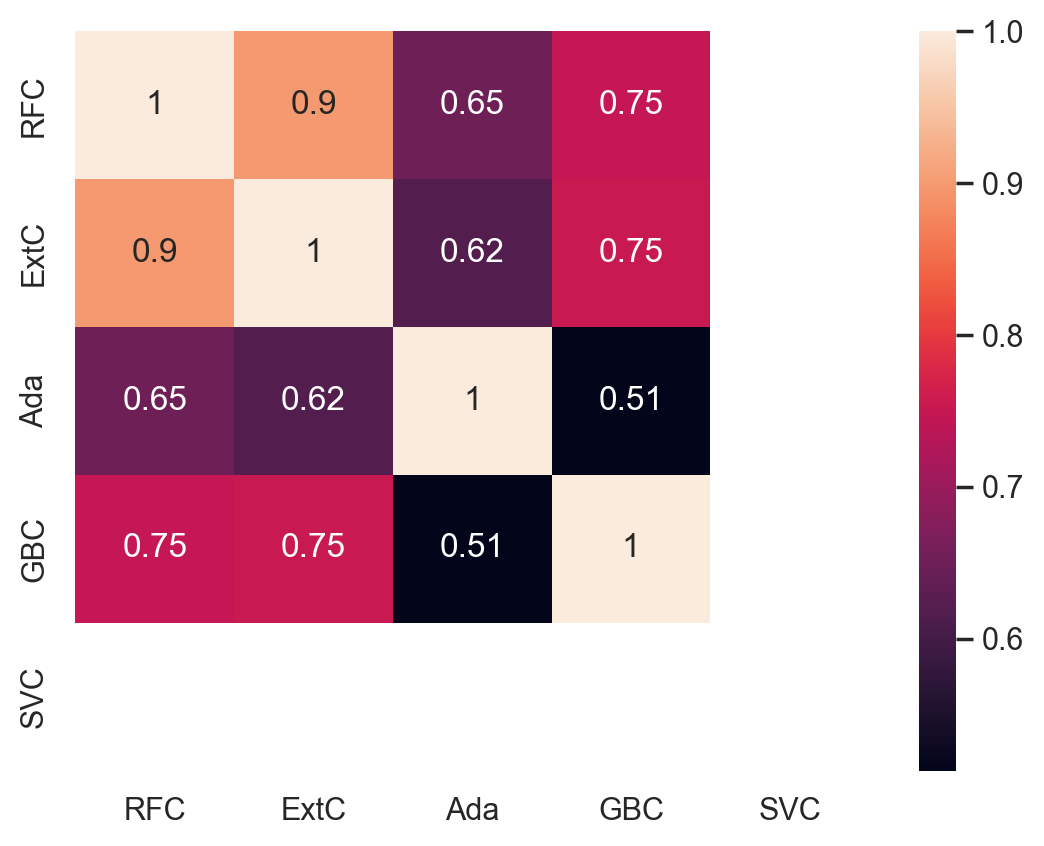

In [232]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name = 'RFC')
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name = 'ExtC')
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name = 'SVC')
test_Survived_AdaC = pd.Series(ada_best.predict(test), name = 'Ada')
test_Survived_GBC = pd.Series(GBC_best.predict(test), name = 'GBC')

# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC, test_Survived_ExtC, test_Survived_AdaC, test_Survived_GBC, test_Survived_SVMC], axis =1)

g = sns.heatmap(ensemble_results.corr(), annot = True)

## 6.2 Ensemble modeling

### 6.2.1 Combining models

In [233]:
votingC = VotingClassifier(estimators = [('rfc', RFC_best), ('extc', ExtC_best), ('svc', SVMC_best), ('adac', ada_best), ('gbc', GBC_best)], voting = 'soft', n_jobs = 10)

votingC = votingC.fit(X_train, Y_train)

## 6.3 Prediction

### 6.3.1 Predict and submit results

In [234]:
test_Survived = pd.Series(votingC.predict(test), name = 'Survived')

results = pd.concat([IDtest, test_Survived], axis =1)

results.to_csv('~/aiffel/data/titanic_submission2.csv', index = False)